<h1 id="parta"
    style="font-size:22px; font-weight: 500; background-color: #E6E6E6; color: black; height: 50px; line-height: 46px; padding-left: 14px;">
    Part A: Quick & Easy
    <a class="anchor-link"
       href="#parta"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
</h1>

In Part A, we establish a baseline for model performance using a straightforward yet effective CatBoost algorithm that provides a quick insight into the predictive power of our dataset. As we progress through Parts B and C, we will explore more advanced models and optimization methods to enhance our predictions and better understand loan repayment behavior.

<h1 id="a01"
    style="font-size:18px; font-weight:bold;">
    1. Developing an Initial Baseline Machine Learning Model
    <a class="anchor-link"
       href="#a01"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In this very first section, we will quickly build a basic machine learning model for the binary classification task of predicting loan repayment difficulties. This baseline model will serve as a benchmark for all subsequent machine learning models.

<h2 style="font-size:16px; font-weight:bold;">1.1 Setting Up the Modeling Environment</h2>

We begin by importing all required libraries, calibrating visualization parameters, and setting a random seed to ensure the reproducibility of our results.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

In [ ]:
import os
# Set environment variable to ignore all warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

# Standard Python libraries for data analysis, scientific computing, and plotting
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from scipy.stats import uniform, loguniform
!pip install pyarrow_hotfix # due to PyArrow security vulnerability
import pyarrow_hotfix

# Setting display options for pandas and matploblib
pd.set_option('display.max_columns', None)
COLOR_LIGHT, COLOR_DARK = '#849CBE', '#00548A'

# Scikit-learn modules for preprocessing and machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Gradient boosting frameworks and logistic regression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm.callback import log_evaluation
import statsmodels.formula.api as smf

# Explainable AI methods
import shap
shap.initjs()

# Tensorflow and Keras for artificial neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import set_random_seed
!pip install scikeras
from scikeras.wrappers import KerasClassifier

# Ensure reproducibility
RANDOM_SEED = 123
set_random_seed(RANDOM_SEED)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


2024-02-07 20:49:55.465475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 20:49:55.465611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 20:49:55.620468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


To optimize resource usage, we adjust TensorFlow's GPU memory settings, enabling efficient computation throughout our modeling workflow.

In [ ]:
# Prevent TensorFlow From Fully Allocating GPU Memory
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


<h2 style="font-size:16px; font-weight:bold;">1.2 Load and examine the input data</h2>

In [ ]:
# Load the dataset into a pandas DataFrame
df_raw = pd.read_csv("")

# Display the dimensions of the dataset (rows, columns)
print(f"Input Dataset dimensions (rows, columns): {df_raw.shape}")

# Display a random sample of 10 rows from the dataset to inspect data
df_raw.sample(n=7, random_state=RANDOM_SEED)

Input Dataset dimensions (rows, columns): (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
58296,167580,0,Cash loans,F,N,Y,0,157500.0,1174090.5,49873.5,1080000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018801,-14327,-3247,-1828.0,-4444,NaN,1,1,1,1,0,0,Sales staff,2.0,2,2,TUESDAY,8,0,0,0,0,0,0,Trade: type 7,NaN,0.440505,0.297087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-328.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
286459,431774,0,Cash loans,F,N,Y,0,67500.0,227520.0,13189.5,180000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.019101,-15588,-411,-9466.0,-3958,NaN,1,1,0,1,0,0,Cooking staff,2.0,2,2,SATURDAY,11,0,0,0,0,0,0,Kindergarten,NaN,0.328679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-150.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
81217,194173,0,Cash loans,F,N,Y,0,90000.0,90000.0,9351.0,90000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010500,-16507,-3147,-3612.0,-47,NaN,1,1,1,1,1,0,Sales staff,2.0,3,3,TUESDAY,9,0,0,0,0,0,0,Business Entity Type 3,NaN,0.171259,0.511892,NaN,0.0429,0.9801,NaN,NaN,NaN,0.0345,0.1667,NaN,NaN,NaN,0.029,NaN,NaN,NaN,0.0445,0.9801,NaN,NaN,NaN,0.0345,0.1667,NaN,NaN,NaN,0.0302,NaN,NaN,NaN,0.0429,0.9801,NaN,NaN,NaN,0.0345,0.1667,NaN,NaN,NaN,0.0295,NaN,NaN,NaN,NaN,0.0228,"Stone, brick",No,7.0,0.0,7.0,0.0,-689.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
102593,219096,1,Cash loans,M,Y,Y,0,405000.0,640080.0,29970.0,450000.0,Unaccom

Subsequently, we will assess the balance of the dataset by plotting the distribution of the 'TARGET' variable.

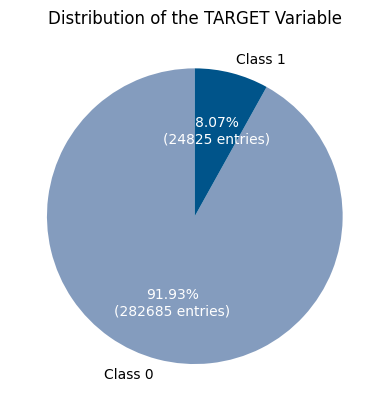

In [ ]:
# Count the occurrences of each unique value in the 'TARGET' column
target_counts = df_raw['TARGET'].value_counts()

# Calculate the total number of entries
total_entries = len(df_raw['TARGET'])

# Define a custom formatting function for the pie chart labels
def custom_autopct(pct):
    absolute = int(pct/100.*total_entries)
    return "{:.2f}%\n({:d} entries)".format(pct, absolute)

# Create a pie chart to visualize the distribution of classes in the 'TARGET' column
pie_chart, _, autotexts = plt.pie(target_counts, labels=target_counts.index.map({0: 'Class 0', 1: 'Class 1'}),
                                  autopct=custom_autopct, startangle=90,
                                  colors=[COLOR_LIGHT, COLOR_DARK], wedgeprops={'edgecolor': 'none'})

# Set the color of the autopct texts to white
for autotext in autotexts:
    autotext.set_color('white')

# Plot the pie chart
plt.title('Distribution of the TARGET Variable')
plt.show()

The pie chart illustrates a clear imbalance in the distribution of the dependent variable `TARGET`: The critical class `1` appears significantly less frequently than class `0`.

Accurate classification of rare events is challenging in imbalanced datasets, such as the one observed with the `TARGET` variable. In these scenarios, it is advisable to use the area under the receiver operating characteristic curve (AUC) rather than accuracy as the performance metric. While accuracy reflects overall prediction correctness, it can be misleading by not accounting adequately for the performance on minority classes. In contrast, AUC evaluates a model's ranking ability, which is particularly relevant in distinguishing between classes in imbalanced contexts. AUC measures the trade-off between the true positive rate and the false positive rate, providing a more nuanced understanding of a model's capacity to identify rare events. We will look at this in more detail in Part B.

<h2 style="font-size:16px; font-weight:bold;">1.3 Replacing missing categorical values</h2>

While many machine learning (ML) tools require the more complex data preparation steps described in Part B, CatBoost, the ML tool of our choice, only requires the minimal data preparation implemented below by replacing missing categorical values with a predefined value.

In [ ]:
# Identify categorical features by data type 'object'
categorical_features = list(df_raw.select_dtypes(include=['object']).columns)

# Compute the number of unique values for each categorical feature and reset the index to make 'Feature Names' a column
categorical_feature_counts = df_raw[categorical_features].nunique().reset_index()

# Set the column names to 'Feature' and 'Number of Unique Values'
categorical_feature_counts.columns = ['Categorical Feature', 'Number of Unique Values']

# Sort the DataFrame by 'Number of Unique Values' in descending order
categorical_feature_counts.sort_values(by='Number of Unique Values', ascending=False, inplace=True)

# Display the resulting DataFrame
display(categorical_feature_counts.style.hide(axis='index'))

Categorical Feature,Number of Unique Values
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,18
NAME_INCOME_TYPE,8
NAME_TYPE_SUITE,7
WALLSMATERIAL_MODE,7
WEEKDAY_APPR_PROCESS_START,7
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5
FONDKAPREMONT_MODE,4


Next, we identify those categorical features that contain missing values and calculate the percentage of values that are absent.

In [ ]:
# Define a function that returns a DataFrame with features containing missing values
# and the percentage of missing values for each of these features
def missing_values_percentage(data):
    # Calculate percentages and create a DataFrame
    nan_percentages = data.isna().sum() * 100 / len(data)
    missing_values_df = pd.DataFrame({
        'Categorical Feature': nan_percentages.index,
        'Missing Percent': nan_percentages.values
    })
    # Format the 'Missing Percent' column as a percentage string with two decimal places
    missing_values_df['Missing Percent'] = missing_values_df['Missing Percent'].apply(lambda x: f'{x:.2f}%')
    # Filter out features without missing values and sort by percentage
    missing_values_df = missing_values_df[missing_values_df['Missing Percent'] != '0.00%']
    missing_values_df.sort_values(by='Missing Percent', ascending=False, inplace=True)
    return missing_values_df

# Calculate the proportion of missing values for the categorical features
missing_values_df = missing_values_percentage(df_raw[categorical_features])

# Display the resulting DataFrame without the index using the new recommended Styler.hide method
missing_values_df_styled = missing_values_df.style.hide(axis='index')
display(missing_values_df_styled)

Categorical Feature,Missing Percent
FONDKAPREMONT_MODE,68.39%
WALLSMATERIAL_MODE,50.84%
HOUSETYPE_MODE,50.18%
EMERGENCYSTATE_MODE,47.40%
OCCUPATION_TYPE,31.35%
NAME_TYPE_SUITE,0.42%


To address missing values in categorical columns without imputing data or dropping records, we will assign instances of missing data to a distinct category, `__missingValue__`. This strategy allows our machine learning algorithms to process missingness as an informative feature in its own right, thereby maintaining the dataset's full breadth and the integrity of input for modeling.

In [ ]:
# Replace missing values with a new category '__missingValue__' in all categorical columns
df_raw[categorical_features] = df_raw[categorical_features].fillna('__missingValue__')

<h2 style="font-size:16px; font-weight:bold;">1.4 Partitioning data into training, validation, and test subsets</h2>

When we train a machine learning classifier, we don't just want it to learn to model the training data, or simply memorisz them (ML models can be large and complex enough to do this). We want the model to generalize to data it hasn't seen before. Therefore, model performance is usually measured against a held-out test set consisting of examples that have never been seen before. For consistency with upcoming model optimization strategies, we randomly divide our dataset into three parts:

* <u>Training set</u>: 70% of examples used for model training
* <u>Validation set</u>: 15% to validate our models after the training and possibly decide on changes
* <u>Test set</u>: 15% for the final measurement of the generalization performance of all relevant models (see [Section 11](#a11))

This division allows for effective model training, hyperparameter tuning to prevent overfitting, and unbiased evaluation of performance on new, unseen data.

In [ ]:
# Constants for data split ratios
TRAIN_RATIO = 0.7
VAL_TEST_RATIO = 0.5  # Splitting the remaining 30% equally into validation and test

# Separate the features (X) and the target (y)
X_raw = df_raw.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = df_raw['TARGET']

# Split the dataset into a training set and a combined validation and test set
X_raw_train, X_raw_val_test, y_train, y_val_test = train_test_split(X_raw, y, train_size=TRAIN_RATIO, random_state=RANDOM_SEED)

# Further split the combined validation and test set into separate validation and test sets
X_raw_val, X_raw_test, y_val, y_test = train_test_split(X_raw_val_test, y_val_test, test_size=VAL_TEST_RATIO, random_state=RANDOM_SEED)

# Verify the dimensions of the training, validation, and test sets by displaying (rows, columns)
print(f"Training set dimensions (rows, columns):   {X_raw_train.shape}")
print(f"Validation set dimensions (rows, columns):  {X_raw_val.shape}")
print(f"Test set dimensions (rows, columns):        {X_raw_test.shape}")

Training set dimensions (rows, columns):   (215257, 120)
Validation set dimensions (rows, columns):  (46127, 120)
Test set dimensions (rows, columns):        (46127, 120)


For the three samples, check the mean values and standard deviations of the TARGET variable `y`:

In [ ]:
# Calculate TARGET mean and std for each set
stats = pd.DataFrame({
    'Mean': [y_train.mean(), y_val.mean(), y_test.mean()],
    'Standard Deviation': [y_train.std(), y_val.std(), y_test.std()]
}, index=['Train', 'Validation', 'Test']).round(4)

print(stats)

              Mean  Standard Deviation
Train       0.0803              0.2718
Validation  0.0831              0.2760
Test        0.0803              0.2718


These randomly generated differences in the mean values of the TARGET variables appear small at first, but can have an impact on the final evalution, as we will see in [Section 11](#a11).

<h2 style="font-size:16px; font-weight:bold;">1.5 Training a default CatBoost classifier (baseline model)</h2>

We proceed by applying the CatBoost model to our prepared dataset, utilizing the default settings for a straightforward evaluation without hyperparameter tuning.

In [ ]:
# Start timer to calculate the running time of training the CatBoost model
start_time = time.time()

# Fit the CatBoostClassifier on the training data
CB1 = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_SEED)
CB1.fit(X_raw_train, y_train, cat_features=categorical_features, logging_level='Silent')

# Calculate and print the running time in seconds
elapsed_time_CB1 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_CB1:.2f}")

Elapsed time (sec): 388.62


To showcase the breadth of customization available for refining the CatBoost model, we present a complete list of hyperparameters and their default settings.

In [ ]:
# Display all model hyperparameters in a DataFrame
hyperparams_list = [(k, v) for k, v in CB1.get_all_params().items()]
hyperparams_df = pd.DataFrame(hyperparams_list, columns=['Hyperparameter', 'Value'])
display(hyperparams_df.style.hide(axis='index'))

Hyperparameter,Value
nan_mode,Min
eval_metric,AUC
combinations_ctr,"['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']"
iterations,1000
sampling_frequency,PerTree
fold_permutation_block,0
leaf_estimation_method,Newton
random_score_type,NormalWithModelSizeDecrease
counter_calc_method,SkipTest
grow_policy,SymmetricTree


In order to gain preliminary insights into the trained model's behavior, we visualize the built-in feature importances that highlight the most influential features driving the predictions.

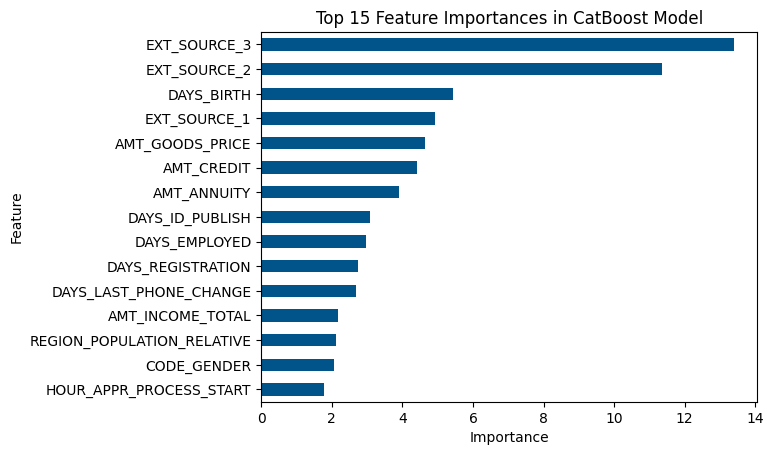

In [ ]:
# Extract the 15 most important features and create a Series for plotting
feature_importances = pd.Series(CB1.feature_importances_, index=X_raw_train.columns).nlargest(15)

# Plot the feature importances
feature_importances.plot(kind='barh', color=COLOR_DARK)
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances in CatBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The feature importance plot above reveals that the most influential predictors are external information sources, specifically `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`, which exert a significant impact. Additionally, the borrower's age, along with financial variables such as the credit amount, annuity payment, and price of goods (`AMT_GOODS_PRICE`, `AMT_CREDIT`, `AMT_ANNUITY`), are highlighted as key features.

We proceed to evaluate the performance of our CatBoost model against the validation set, using the area under the Receiver Operating Characteristic Curve (AUC) as our chosen evaluation metric (see above).

In [ ]:
# Calculate the AUC score using the model's prediction probabilities for the positive class
auc_CB1 = roc_auc_score(y_val, CB1.predict_proba(X_raw_val)[:, 1])

# Print the validation AUC
print(f'The validation AUC of the CatBoost model with standard hyperparameters is: {auc_CB1:.6f}')

The validation AUC of the CatBoost model with standard hyperparameters is: 0.753482


In summary, Part A established a solid baseline for our binary classification task utilizing a CatBoost model with minimal data preparation and without adjustment of its hyperparameters. This is already a complex model, but it is very easy to build and is known for its high predictive power with default parameters. This benchmark serves as a reference point to assess the value of the more elaborate models constructed in the subsequent sections.

<h1 id="partb"
    style="font-size:22px; font-weight: 500; background-color: #E6E6E6; color: black; height: 50px; line-height: 46px; padding-left: 14px;">
    Part B: Generating Insights from Data and Modeling
    <a class="anchor-link"
       href="#partb"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
</h1>

<h1 id="a02"
    style="font-size:18px; font-weight:bold;">
    2. Logistic Regression: A Classical Approach to Classification
    <a class="anchor-link"
       href="#a02"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In this section, we dive into logistic regression, a classical and foundational technique in binary classification tasks. Since this method cannot deal with missing feature values, we start by imputing missing numerical values by median values. We then implement and evaluate a low-parameter classical logistic regression model. Following this, we refit the CatBoost model based on the modified datasets, compare the new model's performance with that of the benchmark model and interpret the result.

<h2 style="font-size:16px; font-weight:bold;">2.1 Preparing the data: Imputing missing numbers with median</h2>

In this subsection, we address the challenge of missing data by imputing these missing values, an essential step since logistic regression requires complete datasets to accurately calculate predictions and model parameters. We have already imputed missing values for categorical features with a distinct category in Subsection 1.3. For numerical features, we choose the median due to its robustness to outliers and its effectiveness in preserving the distribution of skewed datasets. Although median imputation may reduce data variability and possibly introduce bias if the missing data is not random, its simplicity offers a practical approach for setting up a baseline model in binary classification tasks. The code snippet below demonstrates how we impute missing values in numerical features using the median calculated from the training data to prevent data leakage.

In [ ]:
# Identify numerical features
numerical_features = list(X_raw_train.select_dtypes(exclude=['object']).columns)

# Copy the Input Data
df_pre = df_raw.copy()

# Replace missing values for numeric features by median value from the training data
for col in numerical_features:
    median_value = X_raw_train[col].median()
    df_pre[col] = df_pre[col].fillna(median_value)

# Check for remaining missing values:
num_missing = df_pre.isnull().sum().sum()
print(f"\nNumber of missing values after imputation: {num_missing}")


Number of missing values after imputation: 0


While our CatBoost model had no problems with very rare feature values, these initially prevented the upcoming logistic regression from converging. Therefore, we replace the extremely rare values with unknown gender (XNA) with the value “F”.

In [ ]:
# Replace very rare values
print("\nGender_Frequency: ", df_pre.CODE_GENDER.value_counts())
df_pre.loc[df_pre["CODE_GENDER"] != "M", "CODE_GENDER"] = "F"


Gender_Frequency:  CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


As performed previously in Subsection 1.4, we will proceed to divide our preprocessed dataset into separate training, validation, and testing sets accordingly. This crucial step, essential for training, fine-tuning, and evaluating our machine learning models, ensures that our model can be validated and tested on data that it has not seen during the training process.

In [ ]:
# Constants for data split ratios
TRAIN_RATIO = 0.7
VAL_TEST_RATIO = 0.5  # Splitting the remaining 30% equally into validation and test

# Separate the features (X) and the target (y) after preprocessing
X_pre = df_pre.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y_pre = df_pre['TARGET']

# Split the preprocessed dataset into a training set and a combined validation and test set
X_pre_train, X_pre_val_test, y_pre_train, y_pre_val_test = train_test_split(X_pre, y_pre, train_size=TRAIN_RATIO, random_state=RANDOM_SEED)

# Further split the combined validation and test set into separate validation and test sets
X_pre_val, X_pre_test, y_pre_val, y_pre_test = train_test_split(X_pre_val_test, y_pre_val_test, test_size=VAL_TEST_RATIO, random_state=RANDOM_SEED)

# Verify the dimensions of the training, validation, and test sets by displaying (rows, columns)
print(f"Preprocessed training set dimensions (rows, columns):   {X_pre_train.shape}")
print(f"Preprocessed validation set dimensions (rows, columns): {X_pre_val.shape}")
print(f"Preprocessed test set dimensions (rows, columns):       {X_pre_test.shape}")

Preprocessed training set dimensions (rows, columns):   (215257, 120)
Preprocessed validation set dimensions (rows, columns): (46127, 120)
Preprocessed test set dimensions (rows, columns):       (46127, 120)


<h2 style="font-size:16px; font-weight:bold;">2.2 Logistic regression implementation: Fitting and performance evaluation</h2>

Preparing for a logistic regression analysis that echoes R's formula-based modeling style, we merge the features and target variable into a single dataframe. This setup facilitates the use of statsmodels' formula API to define and fit the logistic regression model succinctly. Mindful of potential overfitting and convergence issues, we strategically select only the top 12 features out of the original 120, guided by their importance rankings determined by CatBoost in Subsection 1.5. Once the model has been fitted, we provide a comprehensive overview of the logistic regression results to facilitate interpretation and analysis.

In [ ]:
# Combine features and target variable into a single dataframe for formula-based modeling
Xy_pre_train = X_pre_train.copy()
Xy_pre_train['TARGET'] = y_pre_train

# Start timer to calculate the running time of training the logistic regression model
start_time = time.time()

# Define the logistic regression model using statsmodels' formula API and fit it to the training data
LR1 = smf.logit(formula="TARGET ~ EXT_SOURCE_3 + EXT_SOURCE_2 + EXT_SOURCE_1 + DAYS_BIRTH \
                         + AMT_GOODS_PRICE + AMT_CREDIT + AMT_ANNUITY + AMT_INCOME_TOTAL \
                         + DAYS_ID_PUBLISH + DAYS_REGISTRATION + DAYS_EMPLOYED + CODE_GENDER",
                data=Xy_pre_train).fit()

# Calculate and print the running time in seconds
elapsed_time_LR1 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_LR1:.2f}")

# Display a summary of the logistic regression model results
print(LR1.summary())

Optimization terminated successfully.
         Current function value: 0.253335
         Iterations 7
Elapsed time (sec): 1.43
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               215257
Model:                          Logit   Df Residuals:                   215244
Method:                           MLE   Df Model:                           12
Date:                Wed, 07 Feb 2024   Pseudo R-squ.:                 0.09372
Time:                        20:57:06   Log-Likelihood:                -54532.
converged:                       True   LL-Null:                       -60172.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6308      0.045     13.942      0.000       0

Now that our logistic regression model is trained, we evaluate its performance on the validation set by calculating the AUC, which provides us with a single metric summarizing the model's ability to discriminate between the positive and negative classes.

In [ ]:
# Evaluate the performance of the logistic regression model on the validation data
# and calculate the Area Under the Curve (AUC) for the ROC
auc_LR1 = roc_auc_score(y_pre_val, LR1.predict(X_pre_val))

# Print the validation AUC
print(f'The validation AUC of the logistic regression model is: {auc_LR1:.6f}')

The validation AUC of the logistic regression model is: 0.724853


<h2 style="font-size:16px; font-weight:bold;">2.3 Data imputation impact: Re-evaluating CatBoost with median replacement</h2>

In [ ]:
# Start timer to calculate the running time of training the CatBoost model with median replacement
start_time = time.time()

# Initialize a CatBoostClassifier and fit it to the preprocessed training data
CB2 = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_SEED)
CB2.fit(X_pre_train, y_train, cat_features=categorical_features, logging_level='Silent')

# Calculate and print the running time in seconds
elapsed_time_CB2 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_CB2:.2f}")

Elapsed time (sec): 362.67


In [ ]:
# Evaluate the performance of the CatBoost model with median replacement on the
# validation data and calculate the Area Under the Curve (AUC) for the ROC
auc_CB2 = roc_auc_score(y_val, CB2.predict_proba(X_pre_val)[:,1])
print(f'The validation AUC of the CatBoost model with median replacement is:   {auc_CB2:.6f}')
print(f'The validation AUC of the CatBoost model with minimum replacement was: {auc_CB1:.6f}')

The validation AUC of the CatBoost model with median replacement is:   0.752639
The validation AUC of the CatBoost model with minimum replacement was: 0.753482


Our evaluation reveals a comparable validation AUC for the CatBoost model with both median and minimal value imputation of missing numerical data. Given CatBoost's use of randomness, slight performance variations between the two methods could occur on different runs.

<h1 id="a03"
    style="font-size:18px; font-weight:bold;">
    3. Exploratory Data Analysis and Feature Engineering
    <a class="anchor-link"
       href="#a03"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In Section 3, we conduct a focused Exploratory Data Analysis (EDA), analyzing the dataset's most significant categorical and numerical variables, and then explore feature engineering to conceive new attributes with the potential to elevate our models' predictive capabilities. Facing a dataset with roughly a hundred numerical features, we will concentrate on a selection of pivotal numerical features identified in Subsection 1.5, along with a handful of categorical features of particular interest.

<h2 style="font-size:16px; font-weight:bold;">3.1 Analysis of categorical features</h2>

First, we examine five selected categorical variables—gender, education, family status, contract type, and occupation—to gauge their influence on loan repayment risk. Our analysis involves:

1. Creating stacked bar charts to contrast borrower counts and percentage distributions across different categories with respect to the target outcome.
2. Comparing the raw number of defaults to the proportion within each category to uncover potential predictive patterns.

By examining both the count and percentage distributions side by side, we can better understand how each categorical feature correlates with the likelihood of a borrower facing repayment difficulties.

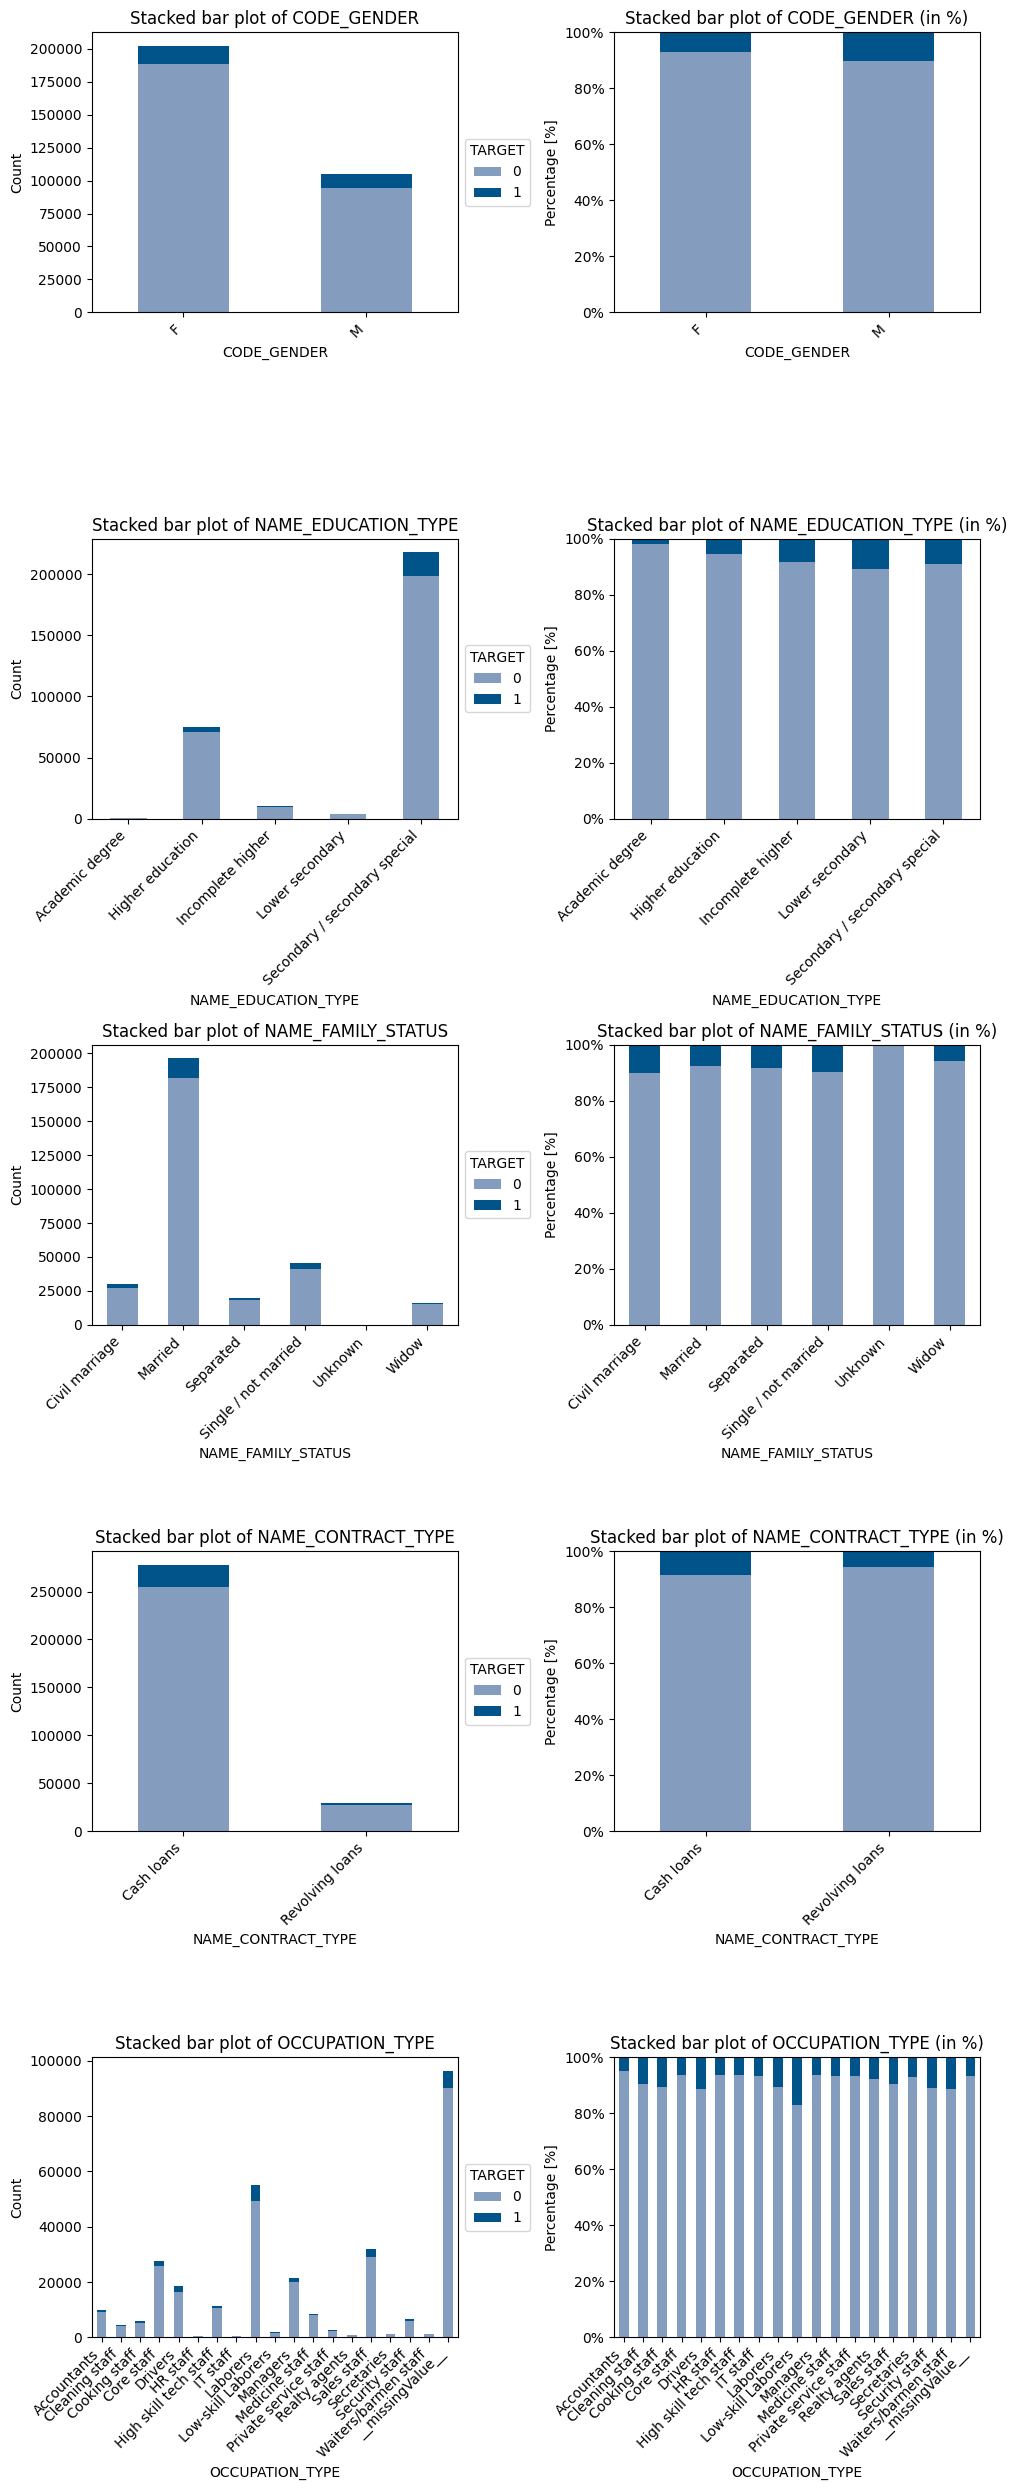

In [ ]:
# List of selected categorical features to analyze
selected_categorical_features = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE']

# Number of rows/columns for the subplot grid
n_cols = 2  # doubled to fit count and percentage plots side by side
n_rows = len(selected_categorical_features)  # one row for each feature

# Set up the matplotlib figure
plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Loop through the number of categorical features
for idx, feature in enumerate(selected_categorical_features):
    # Create a crosstab for stacked bar plot structure
    ctab = pd.crosstab(df_pre[feature], df_pre['TARGET'])

    # (1st column) add a new subplot iteratively for count values
    ax1 = plt.subplot(n_rows, n_cols, idx * n_cols + 1)

    # Create a stacked bar plot for count values
    ctab.plot(kind="bar", stacked=True, color=[COLOR_LIGHT, COLOR_DARK], edgecolor="none", ax=ax1)

    # Additional plot settings for count subplot
    ax1.set_title(f'Stacked bar plot of {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')
    ax1.legend(title='TARGET', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45, ha='right')

    # (2nd column) add a new subplot iteratively for percentage values
    ax2 = plt.subplot(n_rows, n_cols, idx * n_cols + 2)

    # Normalize the crosstab by row and multiply by 100 to convert to percentages
    ctab_normalized = ctab.div(ctab.sum(axis=1), axis=0) * 100

    # Create a stacked bar plot for percentage values
    ctab_normalized.plot(kind="bar", stacked=True, color=[COLOR_LIGHT, COLOR_DARK], edgecolor="none", ax=ax2)

    # Additional plot settings for percentage subplot
    ax2.set_title(f'Stacked bar plot of {feature} (in %)')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Percentage [%]')
    ax2.legend().remove()
    plt.xticks(rotation=45, ha='right')

    # Make yticks be in percentages for the percentage subplot
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(int(x))))
    ax2.set_ylim(0, 100)

# Preventing subplots from being too close to each other and display the final plot
plt.tight_layout()
plt.show()

Insights from the categorical feature analysis within the Home Credit Default Risk dataset suggest:

- Higher education (`NAME_EDUCATION_TYPE`) and advanced occupational (`OCCUPATION_TYPE`) correlate with lower default rates, whereas lesser education and basic occupations are linked to higher defaults.
- Male applicants (`CODE_GENDER`) show a higher tendency to default than females.
- Loan type matters; cash loans exhibit a higher default risk than revolving loans (`NAME_CONTRACT_TYPE`).
- Family status (`NAME_FAMILY_STATUS`) shows no significant variation in default rates.
- Rare categories like `XNA` in `CODE_GENDER` and `UNKNOWN` in `NAME_FAMILY_STATUS` may be omitted from models to streamline the feature set.

As with any data-driven insights, statistical validation is advisable before applying these findings.

<h2 style="font-size:16px; font-weight:bold;">3.2 Analysis of numerical features</h2>

Next, we analyze key numerical variables—such as external scores and amounts relevant to the loan—to detect patterns related to loan repayment outcomes. Through Kernel Density Estimation (KDE) plots, we observe the density distribution of each feature for both defaulting and non-defaulting clients. By comparing these distributions, we can identify which numerical predictors might have significant predictive power, a critical step for effective feature engineering and subsequent model building in binary classification tasks.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

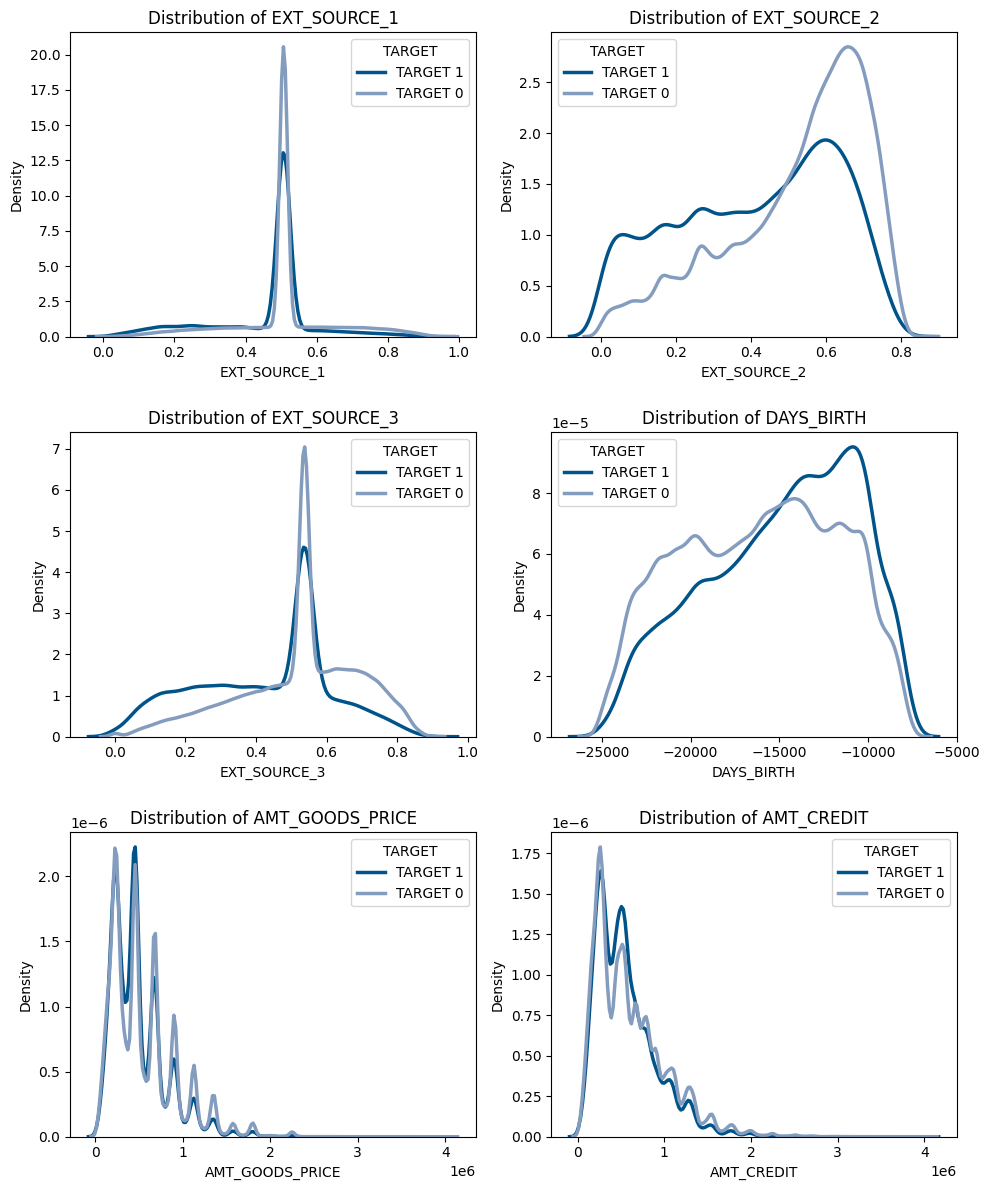

In [ ]:
# List of selected numerical features to analyze
selected_numerical_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_GOODS_PRICE', 'AMT_CREDIT']

# number of plots, set up the subplot grid
n_plots = len(selected_numerical_features)
n_cols = 2  # adjust the number of columns based on your preference
n_rows = (n_plots + n_cols - 1) // n_cols

# set up the matplotlib figure
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# loop through the list of numerical features
for idx, feature in enumerate(selected_numerical_features):
    ax = plt.subplot(n_rows, n_cols, idx + 1)

    # Create a color mapping based on TARGET values assuming values are 0 and 1
    color_mapping = {0: COLOR_LIGHT, 1: COLOR_DARK}

    class_vals = df_pre['TARGET'].unique()
    for val in class_vals:
        subset = df_pre[df_pre['TARGET'] == val]

        # Draw the KDE for each class
        sns.kdeplot(subset[feature], ax=ax, label=f'TARGET {val}', color=color_mapping[val], linewidth=2.5)

    # additional plot settings
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Density')
    ax.legend(title='TARGET')

# Preventing subplots from being too close to each other and display the final plot
plt.tight_layout()
plt.show()

The analysis of numerical features within the Home Credit Default Risk dataset yields the following key insights:

- `EXT_SOURCE` features, which likely represent external credit scores, show a noticeable negative correlation with default risk. Higher values of `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` are associated with lower probabilities of defaulting.
- `DAYS_BIRTH`, representing the age of the applicant in days, exhibits that younger applicants are more prone to defaulting. There is a trend suggesting that the risk of default decreases with age.
- `AMT_GOODS_PRICE`, indicating the value of the goods for which the loan is taken, suggests that lower-priced goods correlate with a higher likelihood of default.
- Similarly, `AMT_CREDIT`, the total credit amount borrowed, is observed to have a relationship with default rates, with smaller loans having a tendency towards higher default frequencies.

<h2 style="font-size:16px; font-weight:bold;">3.3 Feature Engineering: Creating ratio-based features</h2>

In finance and insurance, ratios of financial metrics like loan amount to income often reveal insights and boost prediction. Consequently, we derive several such ratio variables to examine their correlation coefficients.

In [ ]:
# Feature engineering
df_pre['RATIO_CREDIT_ANNUITY'] = df_pre['AMT_CREDIT'] / df_pre['AMT_ANNUITY']
df_pre['RATIO_GOODS_PRICE'] = df_pre['AMT_CREDIT'] / df_pre['AMT_GOODS_PRICE']
df_pre['RATIO_CREDIT_INCOME'] = df_pre['AMT_CREDIT'] / df_pre['AMT_INCOME_TOTAL']
df_pre['RATIO_ANNUITY_INCOME'] = df_pre['AMT_ANNUITY'] / df_pre['AMT_INCOME_TOTAL']
df_pre['RATIO_ANNUITY_CREDIT'] = df_pre['AMT_ANNUITY'] / df_pre['AMT_CREDIT']
df_pre['RATIO_DAYSEMPLOYED_DAYSBIRTH'] = df_pre['DAYS_EMPLOYED'] / df_pre['DAYS_BIRTH']
# Make a copy to defragment the DataFrame
df_pre = df_pre.copy()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

With our new ratio features created, we now turn to assess how they correlate with one another and with the existing financial variables in our dataset. The heatmap, drawn from the correlation matrix, will illuminate the intensity and patterns of these connections, potentially influencing the stability of our predictive models. Insights gained from this correlations will help decide whether to retain or exclude certain features as we progress.

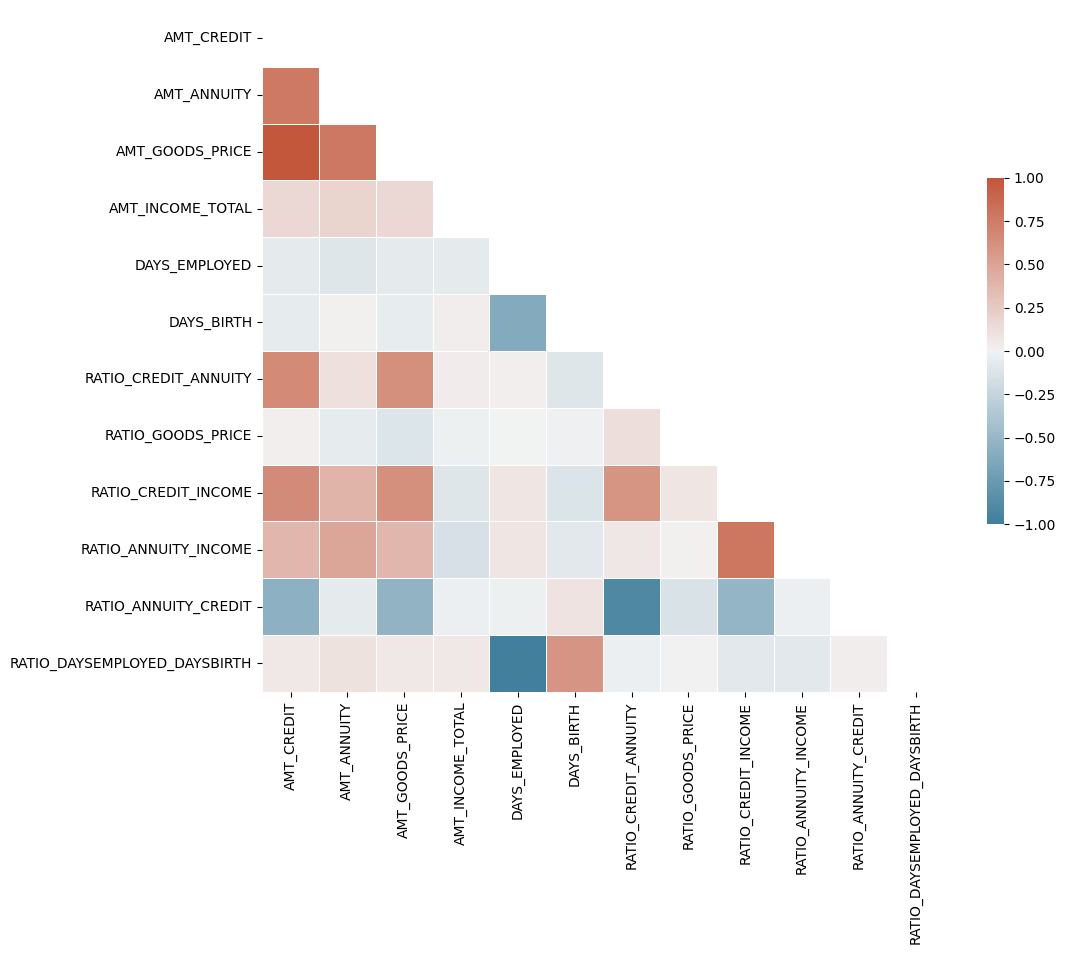

In [ ]:
# Check correlations
feature_selection = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
                     'DAYS_EMPLOYED', 'DAYS_BIRTH', 'RATIO_CREDIT_ANNUITY',
                     'RATIO_GOODS_PRICE', 'RATIO_CREDIT_INCOME', 'RATIO_ANNUITY_INCOME',
                     'RATIO_ANNUITY_CREDIT', 'RATIO_DAYSEMPLOYED_DAYSBIRTH']

# Compute the correlation matrix
corr = df_pre[feature_selection].corr()
#corr = df_pre[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We observe a high (reasonable) positive correlation between the original features `AMT_CREDIT` and `AMT_GOODS_PRICE` as well as high negative correlations with two of our new features. This could affect the stability of future models. Since we do not know this in advance, we first want to see how predictive our new features are compared to the original features. Therefore, at least in this phase, we do not remove any features.

<h1 id="a04"
    style="font-size:18px; font-weight:bold;">
    4. Enhancing CatBoost's Performance with New Features
    <a class="anchor-link"
       href="#a04"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<h2 style="font-size:16px; font-weight:bold;">4.1 Re-fitting baseline model with new features added</h2>

In [ ]:
# Divide the dataset in independent and dependent features
X_pre = df_pre.drop(['TARGET','SK_ID_CURR'], axis=1)
y = df_pre.TARGET

# Split dataset in 70% training, 15% validation and 15% test and devide into feature matrix x and label y
X_pre_train, X_pre_valtest, y_train, y_valtest = train_test_split(X_pre, y, train_size=0.70, random_state=RANDOM_SEED)
X_pre_val, X_pre_test, y_val, y_test = train_test_split(X_pre_valtest, y_valtest, test_size=0.50, random_state=RANDOM_SEED)

print('Sample sizes for training, validation and test: ', X_pre_train.shape, X_pre_val.shape, X_pre_test.shape)

Sample sizes for training, validation and test:  (215257, 126) (46127, 126) (46127, 126)


In [ ]:
# Repeat CB with new features
start_time = time.time()

CB3 = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_SEED)
CB3.fit(X_pre_train,y_train, cat_features=categorical_features, logging_level='Silent')

# Calculate and print the running time in seconds
elapsed_time_CB3 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_CB3:.2f}")

Elapsed time (sec): 367.48


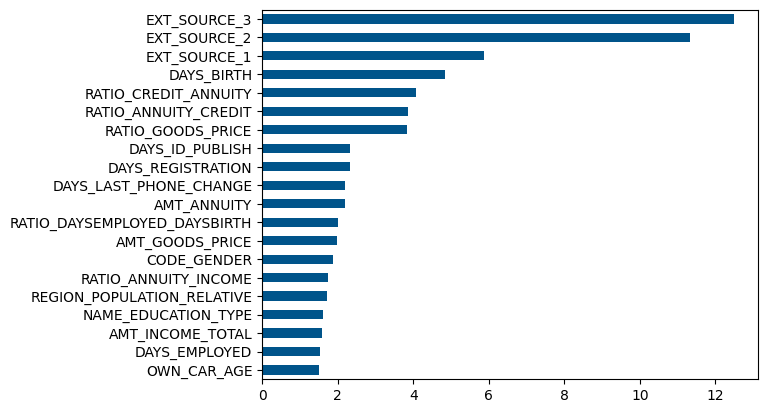

In [ ]:
# CatBoost: Plot most important features
pd.Series(CB3.feature_importances_, index=X_pre_train.columns).nlargest(20).plot(kind='barh', color=COLOR_DARK).invert_yaxis()
plt.show()

We find that three of our new features are among the top seven most important features! This should have an impact on the performance of the model, which we will look at in the next subsection.

<h2 style="font-size:16px; font-weight:bold;">4.2 Model evaluation and comparison</h2>

In [ ]:
# Calculate and dispay the model AUC
auc_CB3 = roc_auc_score(y_val, CB3.predict_proba(X_pre_val)[:,1])
print('The validation AUC of the CatBoost model with new features added is: {:.6f}'.format(auc_CB3))

The validation AUC of the CatBoost model with new features added is: 0.762853


Prepare model comparison:

In [ ]:
# Data structures for model names and AUC
mname = []
mauc = []
dict = {'Model name': mname,'AUC': mauc, }

In [ ]:
# Store name and AUC of prevoisly fitted models
mname.append("CB1_quick")
mauc.append(auc_CB1)
mname.append("LR1_select")
mauc.append(auc_LR1)
mname.append("CB2_median")
mauc.append(auc_CB2)
mname.append("CB3_new_feat.")
mauc.append(auc_CB3)

In [ ]:
def plot_auc(d,x1,x2,t):
    df_eval = pd.DataFrame(d)
    #sns.set_style('darkgrid')
    plt.title(" Model evaluation (AUC): " + t)
    sns.barplot(data = df_eval, x = "AUC", y = "Model name", color = COLOR_DARK)
    plt.xlim(x1, x2)
    plt.show()

Compare Model Performance (AUC - higher is better):

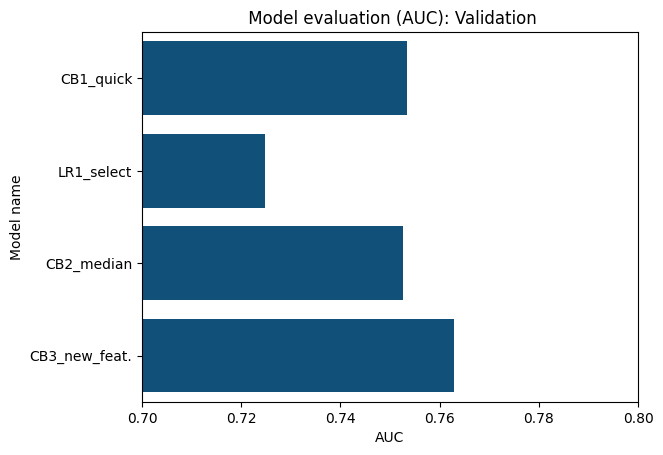

In [ ]:
plot_auc(dict,0.7,0.8, "Validation")

The new features have noticeably improved the performance of our latest CatBoost model. Feature engineering can be the key to improving model performance. In a sense, our most important variables ext_source_* are also the result of (external) feature engineering.

<h1 id="a05"
    style="font-size:18px; font-weight:bold;">
    5. Interpreting Models for Better Understanding
    <a class="anchor-link"
       href="#a05"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

This section is devoted to explainability of the models presented so far. In the first subsection, we take a look at the logistic regression model from [Section 2](#a02) and demonstrate its intrinsical interpretability. In the second subsection, we utilize a model-agnostic explainable AI method (i.e., an explainable AI method that is applicable to any machine learning method) to gain insights into the CatBoost model from [Section 4](#a04).

<h2 style="font-size:16px; font-weight:bold;">5.1 Intrinsical interpretability of logistic regression</h2>

Logistic regression is an intrinsically interpretable machine learning method because it directly models the probability of the outcome variable based on the input features. This allows for easy interpretation of the effect of each input feature on the outcome, as well as the overall model performance. In particular, the sign and the magnitude of the coefficients demonstrate the influence and the importance of the features. Additionally, the coefficients of logistic regression can be easily translated into odds ratios, making it easy to communicate the impact of each feature on the outcome.

We illustrate the ideas above on the particular logistic regression model from [Section 2](#a02). As shown in the mentioned section, the coefficient of the feature `EXT_SOURCE_3` is `-2.5863`. From this value, we can conclude:
* As the coefficient of `EXT_SOURCE_3` is negative, higher values of this feature will result in lower output probabilities.
* As the magnitude of the coefficient of `EXT_SOURCE_3` is comparatively high compared to other coefficients, the effect above is rather high.
* By interpreting the coefficient of `EXT_SOURCE_3` as the change in log odds, the value `-2.5863` shows that an increase of this feature by `1` results in an output probability changed by the factor `0.0756`.

<h2 style="font-size:16px; font-weight:bold;">5.2 Explaining any machine learning model with SHAP</h2>

In the course of this subsection, we illustrate how the model-agnostic explainable AI method SHAP will give insights into the previously created CatBoost model from [Section 4](#a04). SHAP (<u>SH</u>apley <u>A</u>dditive ex<u>P</u>lanations) is an explainable AI method that helps in interpreting the output of any machine learning model. It computes the contribution of each feature in the final prediction in a fair manner. SHAP values range from negative to positive, with higher values indicating a stronger impact on the output. It is based on the concept of Shapley values, a cooperative game theory that assigns a value to each player's contribution in a group's outcome. SHAP can be used to explain the model's decision for a single prediction instance or to provide a global view of the model's behavior.

For the CatBoost model at hand, we utilize the commonly used package `shap` along with its `KernelExplainer` class to calculate SHAP values. Note that this specific implementation internally uses a linear regression step for approximation; more details on this and more general information on SHAP can be found, for instance, in [Mayer, Meier & Wüthrich: SHAP for Actuaries – Explain any Model (2023)](http://dx.doi.org/10.2139/ssrn.4389797).

*Note: The decision to use `KernelExplainer` over (the more natural and more efficient) `TreeExplainer` was made because of the latter's current difficulties in processing the CatBoostClassifier.*

In [ ]:
# Start timer to calculate the running time
start_time = time.time()

# background set & foreground set
shap_bg_set = shap.sample(X_pre_train, 240, random_state=RANDOM_SEED)
shap_fg_set = shap.sample(X_pre_test,  120, random_state=RANDOM_SEED)

# Create a SHAP KernelExplainer using the background set
explainer = shap.KernelExplainer(CB3.predict_proba, shap_bg_set)

# Calculate SHAP values for the foreground set
shap_values = explainer.shap_values(shap_fg_set)[1]

# Calculate and print the running time in seconds
elapsed_time_SHAP = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_SHAP:.2f}")

  0%|          | 0/120 [00:00<?, ?it/s]

Elapsed time (sec): 2375.77


Drawing on the calculated SHAP values, we present a SHAP waterfall plot to illustrate how individual features affect the model's prediction for a specific instance:

1. <u>Base Value</u>: This is the model's average prediction across the dataset, which establishes a starting point for the plot. (→ `0.082` in the example below)

2. <u>Feature Contributions</u>: Each feature's SHAP value is added or subtracted from the base value to show its effect on the prediction, with positive impacts raising and negative ones lowering the predicted outcome.

3. <u>Waterfall Construction</u>: The plot shows a sequential build-up, with each bar representing a feature's contribution, arranged by effect size.

4. <u>Final Prediction</u>: The waterfall ends with the model's actual prediction for the instance, reached after accounting for all feature contributions. (→ `0.013` in the example below)

5. <u>Color Coding</u>: Positive and negative contributions are displayed in different colors for better visual distinction.

The SHAP waterfall plot effectively breaks down a model's prediction process, providing an intuitive visual representation of each feature's contribution.

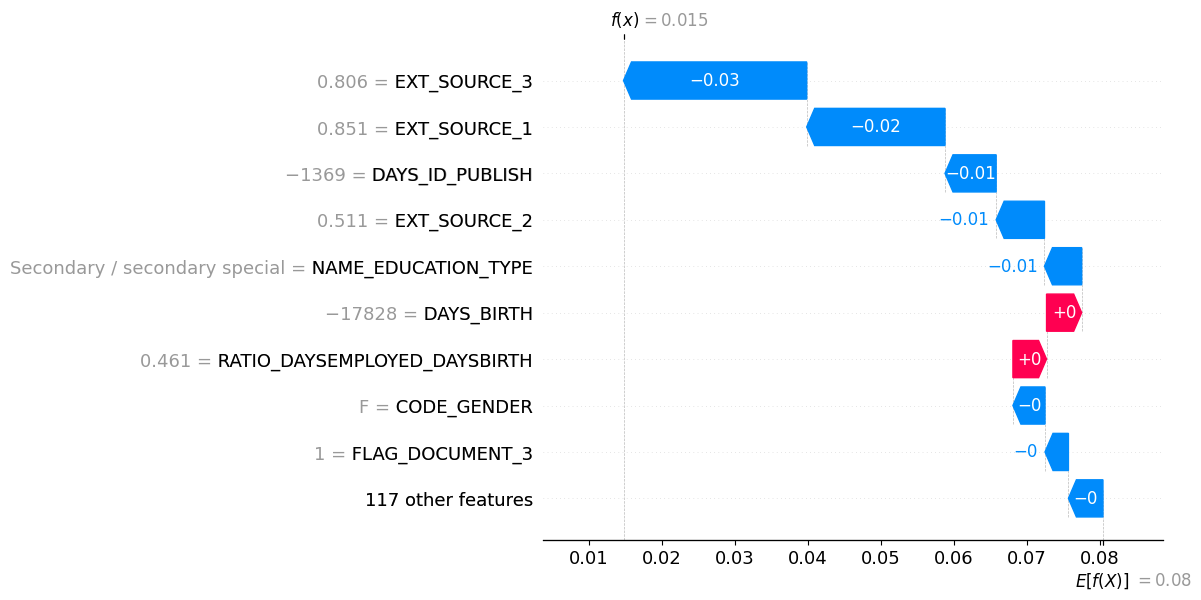

In [ ]:
# Instance in the foreground set that is to be explained
observation_index = 40

# Create an Explanation object for the instance in the foreground set
explanation = shap.Explanation(values=shap_values[observation_index],
                               base_values=explainer.expected_value[1],
                               data=X_pre_test.iloc[observation_index])

# Plot the waterfall chart depicting the 10 most influential features
shap.waterfall_plot(explanation, max_display=10)

The next figure consists of a SHAP feature importance plot (left) and a SHAP summary plot (right). Combined, these plots deliver a comprehensive picture of feature importance and impact, providing both an aggregate and granular understanding of feature influence on model predictions.

The SHAP feature importance plot provides a global view of the impact that each feature has on the model's predictions. By calculating the mean absolute value of the SHAP scores for each feature, the plot ranks the features to show which ones are generally most influential across all predictions. Features are ordered by importance on the y-axis, and the magnitude of their mean absolute SHAP value is displayed along the x-axis. This chart is instrumental in understanding which features drive the model's decisions most strongly.

On the other hand, the SHAP summary plot offers a more detailed perspective. It illustrates the distribution of the SHAP values for each feature across all instances in the dataset. Points on the summary plot represent individual SHAP values for an instance and a feature. The position on the y-axis is determined by the feature, and the x-axis reflects the SHAP value, indicating how much each feature contributes to shifting the model output from the base value. Colors indicate the feature value (red high, blue low). This plot unmasks the relationships between the value of a feature and its impact on the model's predictions, which can differ significantly from one instance to another.

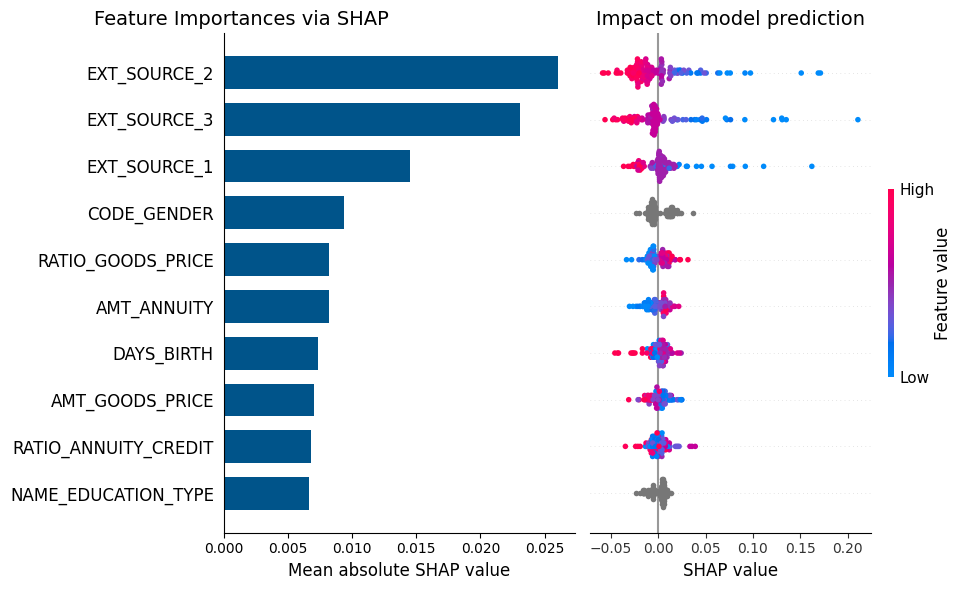

In [ ]:
# Calculate the mean absolute SHAP values for each feature for the positive class
mean_shap_values_positive = np.abs(shap_values).mean(0)

fig = plt.figure()

# Create a SHAP feature importance plot
ax0 = fig.add_subplot(121)
shap.bar_plot(mean_shap_values_positive, feature_names=X_pre_test.columns, max_display=10, show=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    # Ignore last Rectangle
    for fcc in fc.get_children()[:-1]:
        if (isinstance(fcc, matplotlib.patches.Rectangle)):
            fcc.set_facecolor(COLOR_DARK)

# Arrange the layout of the plots
title_obj = plt.title('Feature Importances via SHAP', fontsize=14)
pos = title_obj.get_position()
title_obj.set_position([0.0495, pos[1]])
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=12)
plt.xlabel('Mean absolute SHAP value', fontsize=12)

# Create a SHAP summary plot
ax1 = fig.add_subplot(122)
shap.summary_plot(shap_values, shap_fg_set, max_display=10, show=False)
plt.gcf().axes[-1].set_aspect(30)
plt.title('Impact on model prediction', fontsize=14)
plt.xlabel('SHAP value', fontsize=12)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_yticklabels([])
ax1.set_ylim(-0.85, 9.85)
plt.gcf().set_size_inches(10,6)
plt.tight_layout()
plt.show()

As previously observed in the CatBoost internal feature importance plot in [Section 1](#a01), SHAP also identifies key features such as `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`, and `DAYS_BIRTH` as crucial determinants for the predictions of our CatBoost model. This underscores their significance in the classification task we are examining.

<h1 id="a06"
    style="font-size:18px; font-weight:bold;">
    6. Data Preprocessing: Encoding, Scaling, and Subsampling
    <a class="anchor-link"
       href="#a06"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In this section, we concentrate on two essential preprocessing steps: encoding to make categorical data machine-readable, essential for many machine learning algorithms, and scaling to normalize the values of numerical features, aiding in algorithm efficiency. We also tackle class imbalance by using subsampling methods, creating a more balanced training dataset and boosting computational effectiveness for our machine learning models.

<h2 style="font-size:16px; font-weight:bold;">6.1 Encoding categorical data and scaling numerical values</h2>

In general, machine learning models require input data to be in numerical format to perform mathematical computations. However, real-world datasets—such as the one considered here—frequently contain categorical or text data. Hence, encoding is needed to convert this non-numerical data into a numerical form that can be understood and processed by machine learning algorithms.

The two most commonly used encoding methods are the following:

- <u>Label-Encoding</u>: Converts each value in a column to a number. Good for ordinal data, i.e., when categories have an inherent order.

- <u>One-Hot-Encoding</u>: Creates a binary column for each category/label present in the column. This is useful for nominal variables, where the categories don't have any order or priority.

In the following, we will apply One-Hot-Encoding to our dataset in order to make it processable for machine learning methods such as Artificial Neural Nets or XGBoost.

In [ ]:
# Output the dimensions of the dataset prior to dummy encoding
print("Shape of the dataset before dummy encoding: ", df_pre.shape)

# Perform dummy encoding on categorical features, removing the first level to avoid dummy variable trap
df = pd.get_dummies(df_pre, drop_first=True)

# Output the dimensions of the dataset after dummy encoding to show the change
print("Shape of the dataset after dummy encoding: ", df.shape)

Shape of the dataset before dummy encoding:  (307511, 128)
Shape of the dataset after dummy encoding:  (307511, 241)


In [ ]:
# Change columns names (LightGBM does not support special JSON characters in feature names)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
df = df.rename(columns=new_names)
df.head(1)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,RATIO_CREDIT_ANNUITY,RATIO_GOODS_PRICE,RATIO_CREDIT_INCOME,RATIO_ANNUITY_INCOME,RATIO_ANNUITY_CREDIT,RATIO_DAYSEMPLOYED_DAYSBIRTH,NAME_CONTRACT_TYPE_Revolvingloans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE___missingValue__,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,OCCUPATION_TYPE___missingValue__,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Ele

In [ ]:
# Generate the samples once again

# Split dataset in 70% training, 15% validation and 15% test and devide into feature matrix x and label y
X = df.drop(['TARGET','SK_ID_CURR'], axis=1)
y = df.TARGET
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.50, random_state=RANDOM_SEED)
print('Sample sizes for training, validation and test: ', X_train.shape, X_val.shape, X_test.shape)

Sample sizes for training, validation and test:  (215257, 239) (46127, 239) (46127, 239)


Scaling is vital in machine learning for consistency, improved performance, and meeting algorithm requirements:

1. <u>Uniformity</u>: Diverse features can have varying scales, such as age ranging from 0 to 100 and income spanning thousands to millions. This can mislead algorithms into overemphasizing features with larger ranges.

2. <u>Efficiency</u>: Algorithms such as Gradient Descent and K-Nearest-Neighbors (KNN) benefit from features on a similar scale, resulting in better performance and quicker convergence. For example, KNN is heavily influenced by features with larger magnitudes.

3. <u>Normalization Requirement</u>: Certain machine learning algorithms, such as neural networks, require inputs to be scaled for model training to effectively proceed.

Typical scaling techniques include Min-Max Scaling, which adjusts features to a 0 to 1 range, and Standard Scaling, which sets features to zero mean and unit variance. The appropriate scaling approach is contingent upon the algorithm utilized and data characteristics. We will employ Standard Scaling in our analysis.

In [ ]:
# Generate list: feature names
feature_names=list(X.columns)

# Feature scaling using StandardScaler based on training data distributions
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = feature_names)
X_val = pd.DataFrame(scaler.transform(X_val), columns = feature_names)

<h2 style="font-size:16px; font-weight:bold;">6.2 Do encoding and scaling affect the benchmark model?</h2>

In [ ]:
# Repeat CB with one-hot-encoded and scaled data
start_time = time.time()

CB4 = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_SEED)
CB4.fit(X_train, y_train, logging_level='Silent')

# Calculate and print the running time in seconds
elapsed_time_CB4 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_CB4:.2f}")

Elapsed time (sec): 66.86


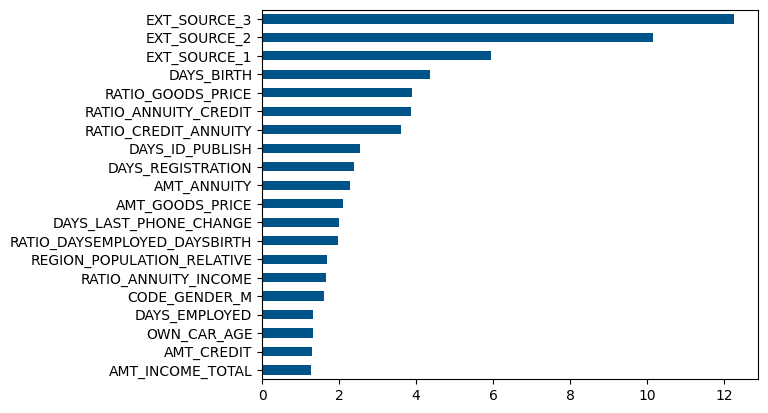

In [ ]:
# CatBoost: Plot most the top 20 most important features
pd.Series(CB4.feature_importances_, index=X_train.columns).nlargest(20).plot(kind='barh', color=COLOR_DARK).invert_yaxis()
plt.show()

Since CODE_GENDER is the only important categorical feature (now CODE_GENDER_M), we can hardly see any difference compared to the corresponding feature-importance-plot in Subsection 4.1.

In [ ]:
# Calculate and dispay the model AUC
auc_CB4 = roc_auc_score(y_val, CB4.predict_proba(X_val)[:,1])
print('The validation AUC of the CatBoost model after encoding and scaling is:   {:.6f}'.format(auc_CB4))
print('The validation AUC of the CatBoost model before encoding and scaling was: {:.6f}'.format(auc_CB3))

The validation AUC of the CatBoost model after encoding and scaling is:   0.761660
The validation AUC of the CatBoost model before encoding and scaling was: 0.762853


In [ ]:
print(f"Elapsed time of the CatBoost model after encoding and scaling (sec):  {elapsed_time_CB4:.2f}")
print(f"Elapsed time of the CatBoost model before encoding and scaling (sec): {elapsed_time_CB3:.2f}")

Elapsed time of the CatBoost model after encoding and scaling (sec):  66.86
Elapsed time of the CatBoost model before encoding and scaling (sec): 367.48


**Summary and interpretation**: Although the encoding of the categorical data almost doubled the number of features (126 before vs. 239 after encoding), the training time of CatBoost decreased substancially while the AUC level decreased just slighly. Apparently, the direct use of the categorical features within CatBoost leads to a greatly increased computational effort, which, however, only leads to a minimal improvement in the prediction quality.

<h2 style="font-size:16px; font-weight:bold;">6.3 Subsampling the training data</h2>

Fortunately, credit default is a rare event and thus the dataset is highly imbalanced with respect to our `TARGET` variable. Currently, one credit default is offset by an average of 11.5 non-defaults in the training data. We would now like to investigate whether this overweight can be reduced to, for example, 1:3 without a deterioration in the resulting model quality and whether the reduced data volume can accelerate model training.

In [ ]:
non_event_factor = 3 # thus the event rate should be 25% (instead of 8%)

# Save complete training data
X_train_all = X_train.copy(deep=True)
y_train_all = y_train.copy(deep=True)

In [ ]:
# Subsampling: enhance event rate to 1:nov_event_factor
Xs = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
Xs = pd.concat([Xs[Xs['TARGET']==1], Xs[Xs['TARGET']==0].sample(
           n = non_event_factor * len(Xs[Xs['TARGET']==1] ), random_state=RANDOM_SEED)],axis=0).sort_index(ascending=True)

# Over-write complete training data with subsample
X_train = Xs.drop(columns=["TARGET"])
y_train = Xs["TARGET"]

print("\nSize of training data set after subsampling: ", X_train.shape)
print("\nTARGET-distribution after subsampling:\n", y_train.value_counts())
print("\nReduction of data volume (%): ", round((len(y_train)/len(y_train_all)-1)*100))


Size of training data set after subsampling:  (69152, 239)

TARGET-distribution after subsampling:
 TARGET
0    51864
1    17288
Name: count, dtype: int64

Reduction of data volume (%):  -68


<h2 style="font-size:16px; font-weight:bold;">6.4 Does subsampling affect the benchmark model?</h2>

In [ ]:
# Repeat CB with subsampled data
start_time = time.time()

CB5 = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_SEED)
CB5.fit(X_train, y_train, logging_level='Silent')

# Calculate and print the running time in seconds
elapsed_time_CB5 = time.time() - start_time
print(f"Elapsed time (sec): {elapsed_time_CB5:.2f}")

Elapsed time (sec): 28.74


In [ ]:
# Calculate and dispay the model AUC
auc_CB5 = roc_auc_score(y_val, CB5.predict_proba(X_val)[:,1])
print('The validation AUC of the CatBoost model with subsampled data is: {:.6f}'.format(auc_CB5))

The validation AUC of the CatBoost model with subsampled data is: 0.762567


**Summary and conclusion**: The smaller amount of training data significantly reduces the training time of CatBoost. In addition, the model performance is even slightly improved. Thus, subsampling training data can be a key component to speed up model training and especially hyperparameter tuning. In the following, we focus on this subsampled dataset with an increased event rate of 25%.

<h1 id="partc"
    style="font-size:22px; font-weight: 500; background-color: #E6E6E6; color: black; height: 50px; line-height: 46px; padding-left: 14px;">
    Part C: Tuning and Applying Machine Learning Models
    <a class="anchor-link"
       href="#partc"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
</h1>

Part C is all about harnessing the full potential of our models by fine-tuning hyperparameters for regularized logistic regression, artificial neural networks, and the gradient tree boosting model champions CatBoost, LightGBM, and XGBoost. We provide a detailed comparative evaluation using validation and test datasets and explore the application of these models in high-risk domains. To wrap up, we summarize the pivotal insights gleaned from our machine learning exploration. As we draw to a close, we reflect on the key learnings from our machine learning journey.

<h1 id="a07"
    style="font-size:18px; font-weight:bold;">
    7. Regularized Logistic Regression to Prevent Overfitting
    <a class="anchor-link"
       href="#a07"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In order to prevent overfitting and avoid convergence problems, the classical logistic regression model in Subsection 2.2 was limited to some of the most important features based on prior knowledge (CatBoost feature importance). Now we are trying to improve this by using all features together with the concept of regularization. Regularized logistic regression is an extension of logistic regression in which a "penalty term" is added to the cost function. The penalty amount is usually determined by cross-validation and prevents the coefficients from becoming too large and leading to overfitting. L1 regularization (as in "LASSO") can result in some coefficients being set to zero, which is a form of feature selection, while L2 regularization (as in "Ridge Regression") results in the corresponding coefficients getting close to zero but not reaching exactly zero.

We use the scikit-learn `LogisticRegression` classifier and optimize the complexity parameter C, which is proportional to the inverse of the penalty. A very low C allows allmost no complexity and will shrink all coefficients towards 0, while a very high C can lead to the same result as the classical logistic regression with all features (i.e. no penalty). To avoid convergence problems when applying the logistic regression classifier, we have to restrict the tolerance parameter considerably, which means that we will probably not achieve the best results.

Since our dataset is quite large and we do have even much more credit default examples than encoded feautures, regularized logistic regression might hardly overfit. For educational purposes, we therefore perform the following steps twice, first with a small part and then with all preprocessed data (see 6.3).

<h2 style="font-size:16px; font-weight:bold;">7.1 Demonstrate underfitting and overfitting on an extract of the data</h2>

After generating an extract of 5% of the relevant data, we fit logistic regression models with L1 and L2 regularization over a wide range of the complexity parameter C.

In [ ]:
fraction = 0.05

# Generating extract of training and validation data
Xs_sel = Xs.sample(n=round(fraction*len(y_train)), random_state=RANDOM_SEED)
X_train_sel = Xs_sel.drop(columns=["TARGET"])
y_train_sel = Xs_sel["TARGET"]
print('Number of data records y_train_sel:', len(y_train_sel))
Xs_sel = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
Xs_sel = Xs_sel.sample(n=round(fraction*len(y_val)), random_state=RANDOM_SEED)
X_val_sel = Xs_sel.drop(columns=["TARGET"])
y_val_sel = Xs_sel["TARGET"]
print('Number of data records y_val_sel:  ', len(y_val_sel))

Number of data records y_train_sel: 3458
Number of data records y_val_sel:   2306


In [ ]:
# Fitting logistic regression models with L1 and L2 regularization
# over a wide range of complexity parameter C
tic = time.time()

# Define lists to collect scores
train_scores_lasso, validation_scores_lasso, train_scores_ridge, validation_scores_ridge = list(), list(), list(), list()

# Define the values of the regularization parameter to evaluate
Cs_lasso = np.logspace(-4, 1, 11)
Cs_ridge = np.logspace(-5, 0, 11)

# Evaluate a logistic regression with L1 regularization for each value of C
print('Logistic regression with L1 regularization (Lasso-like): C, AUC train, AUC val.')
for c in Cs_lasso:
    # Configure the model
    model = LogisticRegression(penalty='l1', C=c, tol=0.01, solver='saga')
    model.fit(X_train_sel, y_train_sel)
    # Evaluate on the train and validation dataset
    train_scores_lasso.append(roc_auc_score(y_train_sel, model.predict_proba(X_train_sel)[:, 1]))
    validation_scores_lasso.append(roc_auc_score(y_val_sel, model.predict_proba(X_val_sel)[:, 1]))
    print('%.5f, train: %.4f, val.: %.4f, non-zero coefficients: %d' % (c, roc_auc_score(y_train_sel, model.predict_proba(X_train_sel)[:, 1]),
                                             roc_auc_score(y_val_sel, model.predict_proba(X_val_sel)[:, 1]),
                                             np.sum(model.coef_.ravel() != 0)))

# Evaluate a logistic regression with L2 regularization for each value of C
print('\nLogistic regression with L2 regularization (Ridge-like): C, AUC train, AUC val.')
for c in Cs_ridge:
    # Configure the model
    model = LogisticRegression(penalty='l2', C=c, tol=0.01, solver='saga')
    model.fit(X_train_sel, y_train_sel)
    # Evaluate on the train and validation dataset
    train_scores_ridge.append(roc_auc_score(y_train_sel, model.predict_proba(X_train_sel)[:, 1]))
    validation_scores_ridge.append(roc_auc_score(y_val_sel, model.predict_proba(X_val_sel)[:, 1]))
    print('%.5f, train: %.4f, val.: %.4f' % (c, roc_auc_score(y_train_sel, model.predict_proba(X_train_sel)[:, 1]),
                                             roc_auc_score(y_val_sel, model.predict_proba(X_val_sel)[:, 1])))

print("\nElapsed time (sec):" + "%6.0f" % (time.time() - tic))

Logistic regression with L1 regularization (Lasso-like): C, AUC train, AUC val.
0.00010, train: 0.5000, val.: 0.5000, non-zero coefficients: 0
0.00032, train: 0.5000, val.: 0.5000, non-zero coefficients: 0
0.00100, train: 0.5000, val.: 0.5000, non-zero coefficients: 0
0.00316, train: 0.6941, val.: 0.6822, non-zero coefficients: 2
0.01000, train: 0.7264, val.: 0.7149, non-zero coefficients: 8
0.03162, train: 0.7514, val.: 0.7264, non-zero coefficients: 57
0.10000, train: 0.7701, val.: 0.7181, non-zero coefficients: 156
0.31623, train: 0.7764, val.: 0.7106, non-zero coefficients: 215
1.00000, train: 0.7776, val.: 0.7082, non-zero coefficients: 234
3.16228, train: 0.7780, val.: 0.7076, non-zero coefficients: 239
10.00000, train: 0.7781, val.: 0.7073, non-zero coefficients: 239

Logistic regression with L2 regularization (Ridge-like): C, AUC train, AUC val.
0.00001, train: 0.7098, val.: 0.6933
0.00003, train: 0.7169, val.: 0.6987
0.00010, train: 0.7300, val.: 0.7076
0.00032, train: 0.7475,

Plot training and validation AUC scores vs regularization parameter:

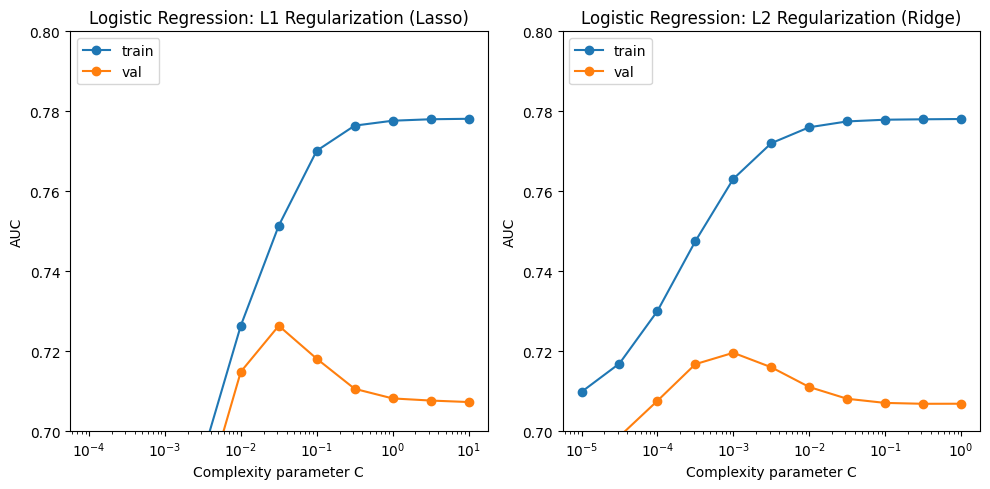

In [ ]:
# Create a figure consisting of two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create the left plot on L1 regularization
ax1.plot(Cs_lasso, train_scores_lasso, '-o', label='Train')
ax1.plot(Cs_lasso, validation_scores_lasso, '-o', label='Validation')
ax1.set_xscale('log')
ax1.set_xlabel('Complexity parameter C')
ax1.set_ylim([0.7, 0.8])
ax1.set_ylabel('AUC')
ax1.set_title('Logistic Regression: L1 Regularization (Lasso)')
ax1.legend(['train', 'val'], loc='upper left')

# Create the right plot on L2 regularization
ax2.plot(Cs_ridge, train_scores_ridge, '-o', label='Train')
ax2.plot(Cs_ridge, validation_scores_ridge, '-o', label='Validation')
ax2.set_xscale('log')
ax2.set_xlabel('Complexity parameter C')
ax2.set_ylim([0.7, 0.8])
ax2.set_ylabel('AUC')
ax2.set_title('Logistic Regression: L2 Regularization (Ridge)')
ax2.legend(['train', 'val'], loc='upper left')

fig.tight_layout()
plt.show()

Based on a 5% extract of our data ("rows"), we detect underfitting if the complexity parameter C is too small and overfitting if C is too large.

<h2 style="font-size:16px; font-weight:bold;">7.2 Using all data</h2>

Now we repeat the fitting procedures from above for the full samples processed in [Section 6](#a06).

In [ ]:
tic = time.time()

# Define lists to collect scores
train_scores_lasso, validation_scores_lasso, train_scores_ridge, validation_scores_ridge = list(), list(), list(), list()

# Define the values of the regularization parameter to evaluate
Cs_lasso = np.logspace(-4, 1, 11)
Cs_ridge = np.logspace(-5, 0, 11)

# Evaluate a logistic regression with L1 regularization for each value of C
print('Logistic regression with L1 regularization (Lasso-like): C, AUC train, AUC val.')
for c in Cs_lasso:
    # configure the model
    model = LogisticRegression(penalty='l1', C=c, tol=0.01, solver='saga')
    model.fit(X_train, y_train)
    # evaluate on the train and validation dataset
    train_scores_lasso.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    validation_scores_lasso.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    print('%.5f, train: %.4f, val.: %.4f, non-zero coefficients: %d' % (c, roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                                             roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
                                             np.sum(model.coef_.ravel() != 0)))

# Evaluate a logistic regression with L2 regularization for each value of C
print('\nLogistic regression with L2 regularization (Ridge-like): C, AUC train, AUC val.')
for c in Cs_ridge:
    # configure the model
    model = LogisticRegression(penalty='l2', C=c, tol=0.01, solver='saga')
    model.fit(X_train, y_train)
    # evaluate on the train and validation dataset
    train_scores_ridge.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    validation_scores_ridge.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    print('%.5f, train: %.4f, val.: %.4f' % (c, roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                                             roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])))

print("\ntime (sec):" + "%6.0f" % (time.time() - tic))

Logistic regression with L1 regularization (Lasso-like): C, AUC train, AUC val.
0.00010, train: 0.5000, val.: 0.5000, non-zero coefficients: 0
0.00032, train: 0.7152, val.: 0.7092, non-zero coefficients: 3
0.00100, train: 0.7350, val.: 0.7282, non-zero coefficients: 20
0.00316, train: 0.7461, val.: 0.7383, non-zero coefficients: 76
0.01000, train: 0.7505, val.: 0.7407, non-zero coefficients: 155
0.03162, train: 0.7516, val.: 0.7410, non-zero coefficients: 224
0.10000, train: 0.7518, val.: 0.7409, non-zero coefficients: 236
0.31623, train: 0.7518, val.: 0.7409, non-zero coefficients: 239
1.00000, train: 0.7518, val.: 0.7409, non-zero coefficients: 239
3.16228, train: 0.7518, val.: 0.7408, non-zero coefficients: 239
10.00000, train: 0.7518, val.: 0.7408, non-zero coefficients: 239

Logistic regression with L2 regularization (Ridge-like): C, AUC train, AUC val.
0.00001, train: 0.7209, val.: 0.7141
0.00003, train: 0.7375, val.: 0.7299
0.00010, train: 0.7471, val.: 0.7381
0.00032, train: 0.

Plot training and validation AUC-scores vs regularization parameter:

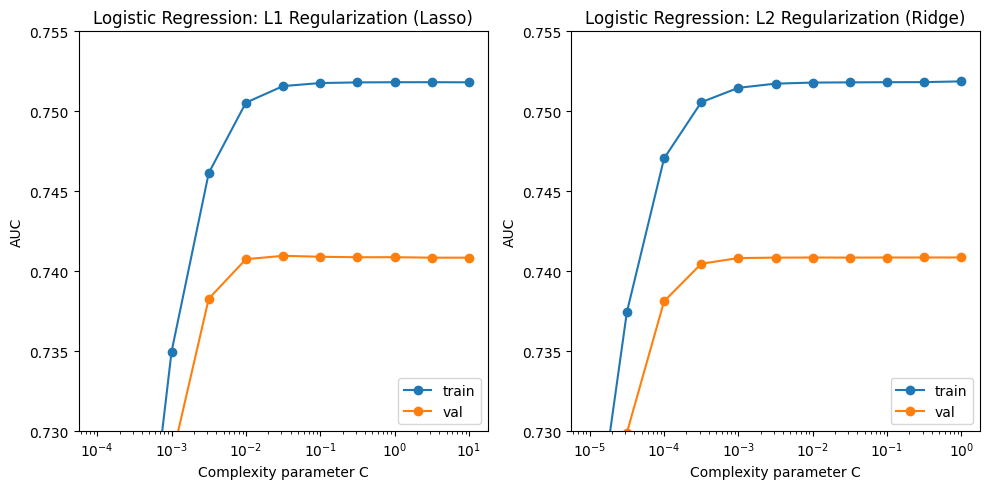

In [ ]:
# Create a figure consisting of two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create the left plot on L1 regularization
ax1.plot(Cs_lasso, train_scores_lasso, '-o', label='Train')
ax1.plot(Cs_lasso, validation_scores_lasso, '-o', label='Validation')
ax1.set_xscale('log')
ax1.set_xlabel('Complexity parameter C')
ax1.set_ylim([0.73, 0.755])
ax1.set_ylabel('AUC')
ax1.set_title('Logistic Regression: L1 Regularization (Lasso)')
ax1.legend(['train', 'val'], loc='lower right')

# Create the right plot on L2 regularization
ax2.plot(Cs_ridge, train_scores_ridge, '-o', label='Train')
ax2.plot(Cs_ridge, validation_scores_ridge, '-o', label='Validation')
ax2.set_xscale('log')
ax2.set_xlabel('Complexity parameter C')
ax2.set_ylim([0.73, 0.755])
ax2.set_ylabel('AUC')
ax2.set_title('Logistic Regression: L2 Regularization (Ridge)')
ax2.legend(['train', 'val'], loc='lower right')

fig.tight_layout()
plt.show()

While we observe underfitting on the left-hand side, there is hardly any overfitting to be seen on the right-hand side of the diagrams (validation: orange). The best validation AUC is determined with L1 regularization and a C around 0.03. We therefore fit this model again and add the result to our model performance gallery:

The validation AUC of the L1 regularized logistic regression model is: 0.740958


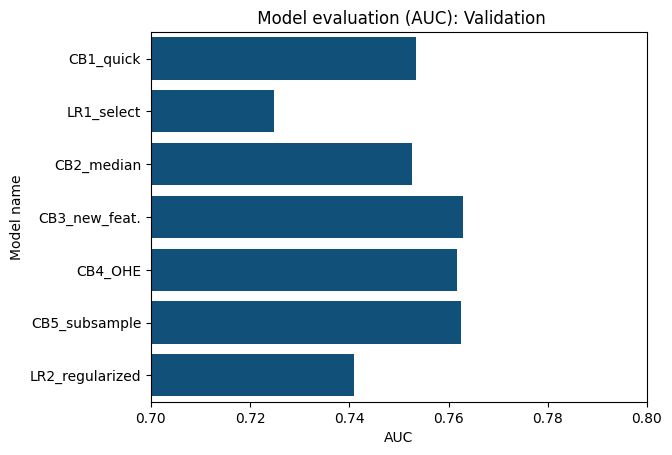

In [ ]:
# Fit the model with the best regularization parameters
LR2 = LogisticRegression(penalty='l1', C=0.03, tol=0.01, solver='saga')
LR2.fit(X_train, y_train)

# Evaluate the performance of the logistic regression model on the validation data
auc_LR2 = roc_auc_score(y_val, LR2.predict_proba(X_val)[:, 1])

# Print the validation AUC
print(f'The validation AUC of the L1 regularized logistic regression model is: {auc_LR2:.6f}')

# Store name and AUC of prevoisly fitted models
mname.append("CB4_OHE")
mauc.append(auc_CB4)
mname.append("CB5_subsample")
mauc.append(auc_CB5)
mname.append("LR2_regularized")
mauc.append(auc_LR2)

# Compare AUC
plot_auc(dict, 0.7, 0.8, "Validation")

The L1 regularized logistic regression model with over 200 non-zero coefficients performs clearly better than the classic logistic regression using only twelve features but cannot keep up with our "quick and easy"-benchmark model.

<h1 id="a08"
    style="font-size:18px; font-weight:bold;">
    8. Optimizing a Feed-Forward Neural Network
    <a class="anchor-link"
       href="#a08"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

We now turn our attention to tuning an artificial neural network by constructing multiple feed-forward neural networks consisting of two to three hidden layers with five to thirty neurons and using the L2 kernel regularizer to add a tunable penalty factor to the layer weights. We fit these models with different optimizers, batch sizes, and epochs.

We use several open-source libraries to accomplish this task. In short, TensorFlow provides the foundation for building and training complex deep learning models, Keras offers a simplified high-level interface for rapid prototyping of these models, and SciKeras bridges the gap between Keras and scikit-learn, enhancing the interoperability of deep learning and traditional machine learning methods.

We start by defining a function to create a scalable, sequential neural network, which is required when using the KerasClassifier from SciKeras.

In [ ]:
# Function to create a (scalable, sequential) keras model, required for KerasClassifier
def create_model(layers, l2_pen):
    # define model
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_shape=(X_train.shape[1],), kernel_initializer = 'glorot_uniform', kernel_regularizer=L2(l2_pen), activation="relu"))
        else:
            model.add(Dense(nodes, kernel_regularizer=L2(l2_pen), activation="relu"))
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L2(l2_pen)))
    # compile model
    model.compile(loss='binary_crossentropy', metrics=['AUC'])
    return model

# Initialize model parameters
layers = [(10,10)]
l2_pen = [0.001]

print(model.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


We then proceed in the usual scikit-learn style and perform hyperparameter optimization with randomized search and cross-validation, a technique described in more detail in section 9.

In [ ]:
# Parameter search range
param_grid = {'layers': [(10,10), (10,5), (20,20), (20,10), (20,20,20), (20,10,5), (30,30,30), (30,20,10)],
              'l2_pen': [0.001, 0.002, 0.005, 0.01],
              'epochs': [5, 10, 25, 50, 75, 100],
              'optimizer':  ['adam', 'nadam'],
              'batch_size': [250, 500] }

# Create a list of variables for displaying the cross-validation result
sel_params = ['param_layers','param_l2_pen','param_epochs','param_optimizer','param_batch_size','mean_test_score','rank_test_score']

In [ ]:
# Create and fit model
tic = time.time()

model = KerasClassifier(model=create_model, layers=layers, l2_pen=l2_pen, verbose=0)
ANN_rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='roc_auc', cv=4, n_iter=20, random_state=RANDOM_SEED)
ANN_rs.fit(X_train, y_train)

print("\ntime (sec):" + "%6.0f" % (time.time() - tic))

I0000 00:00:1707342854.636455      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



time (sec):  1889


In [ ]:
# Display the best parameter sets
print("Best: %f using %s" % (ANN_rs.best_score_, ANN_rs.best_params_))
pd.DataFrame(ANN_rs.cv_results_)[sel_params].sort_values("rank_test_score").head()

Best: 0.747474 using {'optimizer': 'nadam', 'layers': (20, 10), 'l2_pen': 0.005, 'epochs': 100, 'batch_size': 500}


,param_layers,param_l2_pen,param_epochs,param_optimizer,param_batch_size,mean_test_score,rank_test_score
5,"(20, 10)",0.005,100,nadam,500,0.747474,1
14,"(10, 5)",0.005,75,nadam,500,0.747207,2
4,"(10, 5)",0.005,10,nadam,500,0.746928,3
17,"(20, 20, 20)",0.005,25,nadam,500,0.746639,4
15,"(30, 20, 10)",0.005,100,nadam,250,0.746339,5


Since quite different two- and three-layer neural networks lead to almost the same AUC score, this gives the impression of arbitrariness of NN architectures. Small differences in the data samples could therefore lead to a completely different architecture of the neural network being assessed as the best.

In [ ]:
# Fit new model on all folds (with best parameters)
tic = time.time()
ANN = KerasClassifier(model=create_model, **ANN_rs.best_params_, verbose=0)
ANN.fit(X_train, y_train)
print("time (sec):" + "%6.0f" % (time.time() - tic))

time (sec):    42


In [ ]:
# Calculate and dispay the model AUC
auc_ANN = roc_auc_score(y_val, ANN.predict_proba(X_val)[:,1])
mname.append("ANN")
mauc.append(auc_ANN)
print('the validation AUC is: {:.6f}'.format(auc_ANN))

the validation AUC is: 0.739830


Given the poor performance of our tuned neural network compared to the baseline model and the impression of arbitrariness mentioned above, we have decided not to pursue the artificial neural network approach further. Instead, we will again focus on gradient boosting methods, which have repeatedly proven their effectiveness for this dataset and classification tasks of this type.

<h1 id="a09"
    style="font-size:18px; font-weight:bold;">
    9. Hyperparameter Optimization in CatBoost
    <a class="anchor-link"
       href="#a09"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

Now we want to investigate whether we can optimize the learning rate and tree depth of CatBoost by performing a costly cross-validated randomized search (fitting 40 models).

In the first code block, we are setting the stage for hyperparameter optimization of the CatBoostClassifier model. We define a parameter grid specifying the range of values to be explored for the learning rate and the depth of the trees. Here, `loguniform` is used for the learning rate to sample from a logarithmic distribution, optimizing the search over different scales. Similarly, a list of integers represents possible values for the depth of the trees.

In [ ]:
# Define the hyperparameters grid to search
param_grid_CB ={'learning_rate': loguniform(0.015, 0.06),
                'depth':         [4,5,6,7]}

# Define variables for results reports
sel_params_CB = ['param_learning_rate','param_depth','mean_test_score','rank_test_score']

Following the initial setup, our next code block implements the actual hyperparameter optimization using RandomizedSearchCV, a strategy that randomly samples the parameter space and performs four-fold cross-validation. We choose a reasonable number of iterations (`n_iter=10`) to balance between computation time and thoroughness of the search. The results are captured, including the run time and the best parameters found.

In [ ]:
# CatBoostClassifier: Hyper parameter optimization with RandomizedSearchCV
tic = time.time()

CB_rs = RandomizedSearchCV(CatBoostClassifier(iterations=1000, eval_metric='AUC'), param_grid_CB,
                           cv=4, n_iter=10, n_jobs=-1, random_state=RANDOM_SEED, scoring='roc_auc')
CB_rs.fit(X_train, y_train, logging_level='Silent')

# Print the runtime as well as the five best hyper parameter constellations
print("time (sec):" + "%6.0f" % (time.time() - tic))
print("Best hyper parameters:",CB_rs.best_params_)
pd.DataFrame(CB_rs.cv_results_)[sel_params_CB].sort_values("rank_test_score").head()

time (sec):  1198
Best hyper parameters: {'depth': 6, 'learning_rate': 0.04065021889570009}


,param_learning_rate,param_depth,mean_test_score,rank_test_score
2,0.04065,6,0.764306,1
4,0.026515,6,0.764237,2
7,0.041212,4,0.764160,3
0,0.040303,6,0.764159,4
3,0.026967,6,0.764057,5


After identifying the best hyperparameters, we use them to fit a new CatBoostClassifier model with the entire training set. This approach leverages the optimized parameters that should theoretically yield a more accurate model.

In [ ]:
# CatBoostClassifier: Fit new model on all folds (with best parameters)
tic = time.time()
CB6 = CatBoostClassifier(**CB_rs.best_params_, iterations=1000, eval_metric='AUC')
CB6.fit(X_train, y_train, logging_level='Silent')
print("time (sec):" + "%6.0f" % (time.time() - tic))

time (sec):    29


Finally, we evaluate the performance of the tuned model by calculating the AUC score using the validation set.

In [ ]:
# Calculate and dispay the model AUC
auc_CB6 = roc_auc_score(y_val, CB6.predict_proba(X_val)[:,1])
print('The validation AUC of the CatBoost model with tuned hyperparameters is: {:.6f}'.format(auc_CB6))
print('Comparison: The val. AUC of the CatBoost model with subsampled data is: {:.6f}'.format(auc_CB5))

The validation AUC of the CatBoost model with tuned hyperparameters is: 0.762378
Comparison: The val. AUC of the CatBoost model with subsampled data is: 0.762567


Although it requires drastically more training time, the performance of the tuned model is unfortunately worse.

<h1 id="a10"
    style="font-size:18px; font-weight:bold;">
    10. HP-Tuning LightGBM and XGBoost
    <a class="anchor-link"
       href="#a10"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In this section, we turn our attention to CatBoost's primary competitors: LightGBM and XGBoost. Leveraging the power of GPUs for accelerated computation, alongside a more extensive hyperparameter tuning process, we significantly intensify our model fitting efforts by doubling the number of models evaluated. This rigorous comparison aims to benchmark the performance of these leading algorithms under a similar optimization regime.

<h2 style="font-size:16px; font-weight:bold;">10.1 LightGBM: HP-tuning and evaluation</h2>

In [ ]:
# Parameter search range for LightGBM
param_grid_LGB = {'learning_rate':    loguniform(0.01, 0.05),
                  'num_leaves':       [25,32,40,50],
                  'subsample':        uniform(0,1),
                  'colsample_bytree': uniform(0,1),
                  'verbose':          [-1]}

# Create a list of variables for displaying the cross-validation result
sel_params_LGB = ['param_learning_rate', 'param_num_leaves', 'param_subsample',
                  'param_colsample_bytree', 'mean_test_score', 'rank_test_score']

In [ ]:
# LGBMClassifier: Hyperparameter optimization with RandomizedSearchCV
tic = time.time()

LGB_rs = RandomizedSearchCV(LGBMClassifier(device='gpu', n_estimators=1000),
                            param_grid_LGB, cv=4, n_iter=20, scoring='roc_auc',
                            n_jobs=-1, random_state=RANDOM_SEED)
LGB_rs.fit(X_train, y_train)

# Output the runtime and best parameters (as well as the runner-ups)
print("Elapsed time (sec):" + "%6.0f" % (time.time() - tic))
print("Best Parameters:", LGB_rs.best_params_)
pd.DataFrame(LGB_rs.cv_results_)[sel_params_LGB].sort_values("rank_test_score").head()

11 warning warning generated generated.
.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
11 warning generated.
 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

Elapsed time (sec):  1716
Best Parameters: {'colsample_bytree': 0.3122612229724653, 'learning_rate': 0.019861259001425977, 'num_leaves': 32, 'subsample': 0.6934032436025144, 'verbose': -1}


,param_learning_rate,param_num_leaves,param_subsample,param_colsample_bytree,mean_test_score,rank_test_score
10,0.019861,32,0.693403,0.312261,0.765667,1
15,0.020088,25,0.304121,0.282703,0.765481,2
17,0.0154,50,0.624904,0.456748,0.765068,3
12,0.019496,50,0.916699,0.317285,0.764861,4
8,0.027608,40,0.777004,0.293714,0.764729,5


In [ ]:
# LGBMClassifier: Create a new model on all folds using the best parameters
tic = time.time()
LGB = LGBMClassifier(**LGB_rs.best_params_, device='gpu', n_estimators=1000)
LGB.fit(X_train, y_train)
print("Elapsed time (sec):" + "%6.0f" % (time.time() - tic))

Elapsed time (sec):    15


In [ ]:
# Calculate and dispay the model AUC
auc_LGB = roc_auc_score(y_val, LGB.predict_proba(X_val)[:,1])
print('The validation AUC of the LightGBM model with tuned hyperparameters is: {:.6f}'.format(auc_LGB))

The validation AUC of the LightGBM model with tuned hyperparameters is: 0.764781


<h2 style="font-size:16px; font-weight:bold;">10.2 XGBoost: HP-tuning and evaluation</h2>

In [ ]:
# Parameter search range for XGBoost
param_grid_XGB = {'learning_rate':    loguniform(0.01, 0.05),
                  'max_depth':        [4,5,6,7],
                  'subsample':        uniform(0,1),
                  'colsample_bytree': uniform(0,1)}

# Create a list of variables for displaying the cross-validation result
sel_params_XGB = ['param_learning_rate', 'param_max_depth', 'param_subsample',
                  'param_colsample_bytree', 'mean_test_score', 'rank_test_score']

In [ ]:
# XGBClassifier: Hyperparameter optimization with RandomizedSearchCV
tic = time.time()

XGB_rs = RandomizedSearchCV(XGBClassifier(n_estimators=1000, tree_method="hist", device="cuda"),
                            param_grid_XGB, cv=4, n_iter=20, scoring="roc_auc",
                            n_jobs=-1, random_state=RANDOM_SEED)
XGB_rs.fit(X_train, y_train)

# Output the runtime and best parameters (as well as the runner-ups)
print("Elapsed time (sec):" + "%6.0f" % (time.time() - tic))
print("Best Parameters:", XGB_rs.best_params_)
pd.DataFrame(XGB_rs.cv_results_)[sel_params_XGB].sort_values("rank_test_score").head()

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Elapsed time (sec):   489
Best Parameters: {'colsample_bytree': 0.3172854818203209, 'learning_rate': 0.01949624973094681, 'max_depth': 7, 'subsample': 0.9166986737434221}


,param_learning_rate,param_max_depth,param_subsample,param_colsample_bytree,mean_test_score,rank_test_score
12,0.019496,7,0.916699,0.317285,0.764968,1
10,0.019861,5,0.693403,0.312261,0.764939,2
1,0.022043,5,0.980764,0.71915,0.764627,3
19,0.013367,6,0.572457,0.891109,0.764296,4
14,0.012143,6,0.797728,0.612895,0.764249,5


In [ ]:
# XGBClassifier: Create a new model on all folds using the best parameters
tic = time.time()
XGB = XGBClassifier(**XGB_rs.best_params_, n_estimators=1000, tree_method="hist", device="cuda", eval_metric="auc")
XGB.fit(X_train, y_train)
print("Elapsed time (sec):" + "%6.0f" % (time.time() - tic))

Elapsed time (sec):     8


In [ ]:
# Calculate and display the model AUC
auc_XGB = roc_auc_score(y_val, XGB.predict_proba(X_val)[:,1])
print('The validation AUC of the XGBoost model with tuned hyperparameters is: {:.6f}'.format(auc_XGB))

[23:24:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



The validation AUC of the XGBoost model with tuned hyperparameters is: 0.765170


We will compare the performance of LightGBM and XGBoost in the next section and have now reached the end of our modeling approaches.

<h1 id="a11"
    style="font-size:18px; font-weight:bold;">
    11. Model Evaluation and Application
    <a class="anchor-link"
       href="#a11"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<h2 style="font-size:16px; font-weight:bold;">11.1 Model evaluation: Validation and test set</h2>

Now that the modeling is complete, it is time to evaluate our models on test data and compare the results with the validation data and between the different models of interest. We consider all tuned models and two untuned CatBoost models, first the baseline model (cb1) and finally the last and best non-tuned model (cb5).

In [ ]:
# Calulate model AUC based on test data

auc_CB1_test = roc_auc_score(y_test, CB1.predict_proba(X_raw_test)[:, 1])
auc_LR1_test = roc_auc_score(y_test, LR1.predict(X_pre_test))

# Feature scaling using StandardScaler based on training data distributions (6.1)
X_test = pd.DataFrame(scaler.transform(X_test), columns = feature_names)

# Calculate the model test AUC
auc_CB5_test = roc_auc_score(y_test, CB5.predict_proba(X_test)[:,1])
auc_LR2_test = roc_auc_score(y_test, LR2.predict_proba(X_test)[:,1])
auc_ANN_test = roc_auc_score(y_test, ANN.predict_proba(X_test)[:,1])
auc_CB6_test = roc_auc_score(y_test, CB6.predict_proba(X_test)[:,1])
auc_LGB_test = roc_auc_score(y_test, LGB.predict_proba(X_test)[:,1])
auc_XGB_test = roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1])

In [ ]:
# Data structures for model names, val/test-sample and AUC
mdict = {'Model name': [], 'Set': [], 'AUC': []}

# List of models and their AUC scores on validation and test sets
models_auc = [
    ("LR1_select",      auc_LR1, auc_LR1_test),
    ("LR2_regularized", auc_LR2, auc_LR2_test),
    ("ANN_tuned",       auc_ANN, auc_ANN_test),
    ("CB1_quick",       auc_CB1, auc_CB1_test),
    ("CB5_subsample",   auc_CB5, auc_CB5_test),
    ("CB6_tuned",       auc_CB6, auc_CB6_test),
    ("LGB_tuned",       auc_LGB, auc_LGB_test),
    ("XGB_tuned",       auc_XGB, auc_XGB_test)
]

# Populate the dictionary by looping over the models and their AUC scores
for model_name, auc_val, auc_test in models_auc:
    mdict['Model name'].extend([model_name] * 2)  # Model name twice for Val. and Test
    mdict['Set'].extend(["Val.", "Test"])
    mdict['AUC'].extend([auc_val, auc_test])

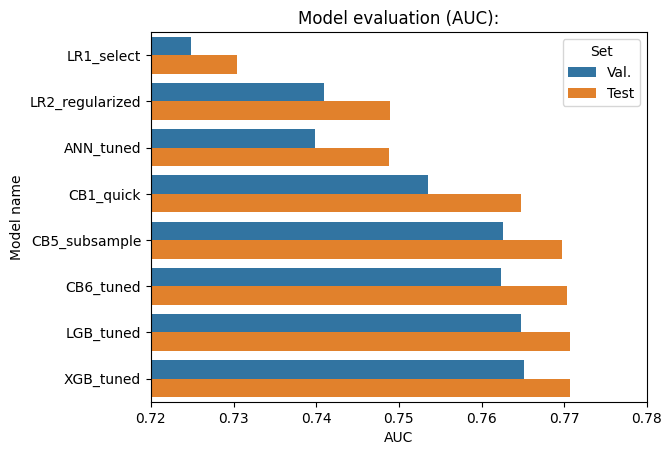

In [ ]:
df_eval = pd.DataFrame(mdict)
plt.title("Model evaluation (AUC):")
sns.barplot(data=df_eval, x="AUC", y="Model name",hue="Set")
plt.xlim(0.72, 0.78)
plt.show()

Surprisingly, all models perform better on the test data. This could be due to differences in the samples and the corresponding TARGET distribution, as indicated in Subsection 1.3.

XGB_tuned seems to have the best prediction quality and hyperparameter tuning is much faster compared to LGB_tuned. The top three models for both samples are CB5_subsample (untuned), LGB_tuned and XGB_tuned, which are all gradient-tree boosting tools. These models have benefited from feature engineering, which is the main reason why they perform better than our base model CB1_quick.

<h2 style="font-size:16px; font-weight:bold;">11.2 High risk prediction</h2>

In Subsection 11.1, we considered a model with the highest area under the Receiver Operating Characteristic Curve (AUC) to be the best based on all loan applications from low to high risk. Since the high-risk area usually receives the most attention for economic reasons, the performance of the models in this area is more decisive for the application. The lift chart is suitable for this evaluation. A cumulative lift chart shows the improvement that a model offers compared to a random estimate and measures the change in the form of a lift scores.

In [ ]:
# Make preditions for test data
y_test_CB1 = CB1.predict_proba(X_raw_test)
y_test_CB5 = CB5.predict_proba(X_test)
y_test_LGB = LGB.predict_proba(X_test)
y_test_XGB = XGB.predict_proba(X_test)
y_test_LR2 = LR2.predict_proba(X_test)
y_test_ANN = ANN.predict_proba(X_test)

In [ ]:
# Core of scikit-plot function cumulative_gain_curve (necessary, since scypi release 1.12.0 broke compatibility with scikit-plot version 0.3.7.
# Source: https://github.com/reiinakano/scikit-plot/blob/26007fbf9f05e915bd0f6acb86850b01b00944cf/scikitplot/helpers.py
def cumulative_gain_curve1(y_true, y_score):
    """This binary classification function generates the points necessary to plot the Cumulative Gain"""
    y_true, y_score = np.asarray(y_true), np.asarray(y_score)
    # make y_true a boolean vector
    y_true = (y_true == 1)
    sorted_indices = np.argsort(y_score)[::-1]
    y_true = y_true[sorted_indices]
    gains = np.cumsum(y_true)
    percentages = np.arange(start=1, stop=len(y_true) + 1)
    gains = gains / float(np.sum(y_true))
    percentages = percentages / float(len(y_true))
    gains = np.insert(gains, 0, [0])
    percentages = np.insert(percentages, 0, [0])
    return percentages, gains

# Calculate cumulative gains for lift chart
def calculate_gains_and_percentages(model_predictions, y_true):
    """Calculate gains and percentages for a given model's predictions."""
    percentages, gains = cumulative_gain_curve1(y_true, model_predictions[:, 1])
    gains_adjusted = gains[1:] / percentages[1:]  # Adjust gains starting from the second element
    return percentages[1:], gains_adjusted


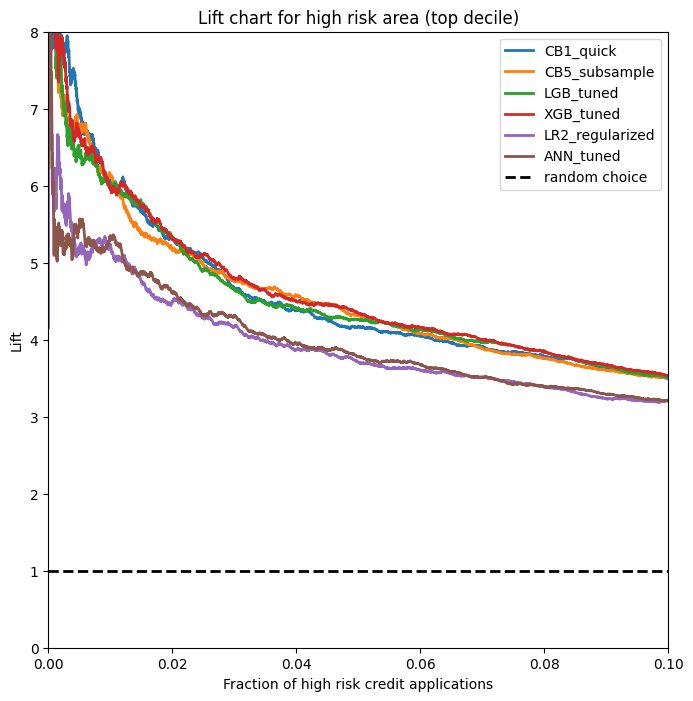

In [ ]:
# Select models and prepare true and predicted values
y_true = np.array(np.ravel(y_test))
model_predictions = {
    'CB1_quick': np.array(y_test_CB1),
    'CB5_subsample': np.array(y_test_CB5),
    'LGB_tuned': np.array(y_test_LGB),
    'XGB_tuned': np.array(y_test_XGB),
    'LR2_regularized': np.array(y_test_LR2),
    'ANN_tuned': np.array(y_test_ANN),
}

# Initialize lift chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Lift chart for high risk area (top decile)")
ax.set_xlabel('Fraction of high risk credit applications')
ax.set_ylabel('Lift')
plt.xlim(0, 0.1)
plt.ylim(0, 8.0)

# Calculate and plot lift score for each model
for label, predictions in model_predictions.items():
    percentages, gains_adjusted = calculate_gains_and_percentages(predictions, y_true)
    ax.plot(percentages, gains_adjusted, lw=2, label=label)

# Plot random choice baseline
ax.plot([0, 1], [1, 1], 'k--', lw=2, label='random choice')
ax.legend(loc='upper right')
plt.show()

The cumulative lift chart shows the factor (lift score) by which the model can improve the "hit rate".
For example, the special consideration of the 6% of applications with the highest probability of default, which have a lift score of 4.2, could already influence 25% of all credit defaults.

In our case, there is no clear winner model for the top decile. All gradient tree boosting models have a similar lift score. Thus, we can take our first "quick & easy" baseline model for defining the top risk area. In the following, we focus on the top decile and create a list of the riskiest loan applications. Since we know the true value for our test data, we compare it with the predicted values.

In [ ]:
# Merge predicted an true values into a DataFrame
df = pd.DataFrame({
    'PredProbability': y_test_CB1[:,1],
    'TrueValue': y_test
})

# Sort by Probability in descending order
df_sorted = df.sort_values(by='PredProbability', ascending=False)
df_sorted.head()

,PredProbability,TrueValue
286882,0.873083,1
294312,0.808917,1
232685,0.776966,0
256048,0.770481,1
263333,0.764354,1


In [ ]:
# Creating a 'Percentile' column based on quantile-based discretization into 100 bins
df_sorted['Percentile'] = pd.qcut(df_sorted['PredProbability'], 100, labels=range(1, 101))

# Calculate means of predicted and true values for the top 10 percentiles
percentile_means = df_sorted.groupby('Percentile', observed=True).mean().tail(10)

# Printing the results for the top 10 percentiles
print(percentile_means[::-1])  # This reverses the order to start with the highest probabilities

            PredProbability  TrueValue
Percentile                            
100                0.510384   0.489177
99                 0.371819   0.364425
98                 0.318389   0.271150
97                 0.284977   0.281385
96                 0.261160   0.268980
95                 0.241063   0.275488
94                 0.225041   0.242950
93                 0.210090   0.238095
92                 0.197297   0.190889
91                 0.186523   0.186551


Although the predicted probabilities seem a little too high, the ranking of percentiles works very well and can be used to decide on the actions to be taken, taking into account the associated quite different costs of lost business opportunities and credit losses.

<h1 id="a12"
    style="font-size:18px; font-weight:bold;">
    12. Key Insights into Model Performance and Binary Classification
    <a class="anchor-link"
       href="#a12"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>



- <u>CatBoost</u>: CatBoost is characterized by the fact that it requires minimal preprocessing, manages categorical features natively, and produces high-quality results quickly and easily in our binary classification task.

- <u>Feature Engineering</u>: The task of enhancing our data through feature engineering proves to be exceptionally worthwhile. By devising financial ratios and relevant interactions among features, we observe a notable uplift in our model's AUC score. This underlines the importance of domain-specific insights in optimizing predictive models.

- <u>Hyperparameter Tuning</u>: While hyperparameter optimization does refine a model's performance, it is feature engineering that stands out as the more influential factor in our classification task. Nevertheless, when fine-tuning is applied to gradient boosting algorithms like LightGBM, we witness a discernible enhancement in model output, marking it as a noteworthy step in the model refinement process.

- <u>Subsampling</u>: Enriching the event rate from 8% to 25% by removing numerous non-events from the training data improves model balance between events and non-events, leading to slightly better predictive quality. This also significantly reduces training times, allowing for further tuning to enhance prediction accuracy.

These findings illustrate the synergy between machine learning techniques and sector-specific expertise, paving the way to more effective credit risk modeling.